# RegFactor Decomposition with scMagnify

## Preliminaries

In this tutorial, you will learn how to:

-   **RegFactor Decomposition.** Decipher the combinatorial effects of transcription factors (TFs) using tensor decomposition.
-   **Enrichment Analysis.** Perform gene functional enrichment analysis based on the resulting Regulons.

---

### The Rationale for Decomposition

In the previous steps, we inferred a GRN and identified key individual regulators. However, it is well-established that TFs rarely act alone; they typically function in a **combinatorial manner** to orchestrate complex gene expression programs {cite}`placeholder_1, placeholder_2`.

To systematically explore these regulatory synergies, `scMagnify` implements a **RegFactor Decomposition** module. This approach is built upon a modified Tucker decomposition, a powerful technique from tensor analysis.

Instead of decomposing raw expression, this method is applied directly to a tensor constructed from the **regulatory coefficients (Reg. scores)** generated by our multi-scale Granger causality model. This allows the decomposition to focus purely on the inferred regulatory logic.

The primary goal is to simultaneously identify:
1.  **Co-regulating TF modules** (groups of TFs that function as a unit).
2.  **Shared sets of Target Genes (TGs)** that are controlled by these modules across different time lags.

This analysis elevates our understanding from individual TF-TG links to the higher-order "teams" of regulators driving the cellular process.

:::seealso
For a complete theoretical breakdown of the tensor decomposition method and the model mathematics, please refer to the **[About the MSNGC](./About the MSNGC.md)** section and the **Methods** section of our manuscript.
:::



### Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from numba.core.errors import NumbaDeprecationWarning
warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [3]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import scanpy as sc
import decoupler as dc

In [5]:
import scmagnify as scm
import scmagnify.logging as logg
from scmagnify.settings import settings


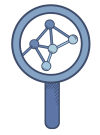

In [6]:
scm.info()

## Configurations

In [9]:
scm.settings.verbosity = 2

In [8]:
%matplotlib inline

scm.settings.set_figure_params(
    dpi=100,
    facecolor="white",
    frameon=False,
) 

scm.load_fonts(["Arial"])
plt.rcParams["font.family"] = "Arial"
plt.rcParams['grid.alpha'] = 0

In [10]:
# Setting a workspace
dirPjtHome = "/mnt/TrueNas/project/chenxufeng/Data/PMID36973557_NatBiotechnol2023_T-cell-depleted/"
workDir = os.path.join(dirPjtHome, "scmagnify_wd")
scm.set_workspace(workDir)

workspace: /mnt/TrueNas/project/chenxufeng/Data/PMID36973557_NatBiotechnol2023_T-cell-depleted/scmagnify_wd/
├── data
├── models
├── tmpfiles
└── figures

In [11]:
# Set up Reference Genome
scm.set_genome(
    version="hg38",
    genomes_dir="/home/chenxufeng/picb_cxf/Ref/human/hg38/"
)

                        Genome Information                        
┏━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Version ┃ Provider ┃ Directory                                 ┃
┡━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ hg38    │ UCSC     │ /home/chenxufeng/picb_cxf/Ref/human/hg38/ │
└─────────┴──────────┴───────────────────────────────────────────┘

## Load the data

In [12]:
gdata = scm.read(os.path.join(settings.data_dir, "t-cell-depleted-bm_NaiveB_final.h5mu"))

/picb/lihonglab/chenxufeng/miniconda3/envs/scm_test/lib/python3.10/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/picb/lihonglab/chenxufeng/miniconda3/envs/scm_test/lib/python3.10/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


## RegFactor Decomposition

The decomposition workflow is a straightforward, multi-step process.

First, we initialize the {py:class}`~scmagnify.tl.RegDecomp` object from our `gdata`. This class automatically extracts the regulatory coefficient tensor and prepares it for decomposition.

In [13]:
decomper = scm.RegDecomp(gdata)

INFO     Initializing RegDecomp object with multiscale mode.

INFO     Filtering Network:                                                                                        
          Method: quantile                                                                                         
          Parameter: 0.0                                                                                           
          Binarize: False

Next, we run the {py:meth}`~scmagnify.tl.RegDecomp.tucker_decomposition` method. This is the core step where the tensor is factorized. The rank parameter is critical, as it defines the number of components (RegFactors) to identify. The log output confirms the tensor shape and the Normalized Reconstruction Error (NRE), which measures how well the decomposition approximates the original data.

In [14]:
decomper.tucker_decomposition(rank=5)

INFO     RegFactor Decomposing with Tucker decomposition:                                                          
          Tensor shape: (5, 105, 2926)                                                                             
          Rank: 5

INFO     Decomposition NRE: 0.82133766130817

Once the RegFactors (TF modules and their TG sets) are defined, we compute an activity score for each factor in each cell. This is done using the `decoupler mlm` method, parallel to the individual TF activity calculation.

In [15]:
decomper.compute_activity()

By default, factors are named numerically. We can use {py:meth}`~scmagnify.tl.RegDecomp.rename_regfactors` to re-order or rename them for better biological interpretation in downstream plots.

In [16]:
decomper.rename_regfactors(
    {
        "RegFactor_1": "RegFactor_3",
        "RegFactor_2": "RegFactor_5",
        "RegFactor_3": "RegFactor_4",
        "RegFactor_4": "RegFactor_1",
        "RegFactor_5": "RegFactor_2",
    },
    sort=True
)

INFO     Sorting RegFactors alphabetically.

INFO     Renaming RegFactors: {'RegFactor_1': 'RegFactor_3', 'RegFactor_2': 'RegFactor_5', 'RegFactor_3':          
         'RegFactor_4', 'RegFactor_4': 'RegFactor_1', 'RegFactor_5': 'RegFactor_2'}

The {py:func}`~scmagnify.pl.circosplot` function provides a comprehensive, all-in-one visualization of the decomposition results. This plot effectively summarizes the key components of the inferred regulatory modules:

- Outer Ring: The top transcription factors (TFs) that contribute most significantly to each RegFactor.
- Inner Heatmap: The time lag associated with each RegFactor.
- Center Plot: An embedding (specified by `embedding_key`) colored by a cell annotation (specified by `color_key`).

2025-10-28 08:57:47 | [INFO] Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
/home/chenxufeng/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


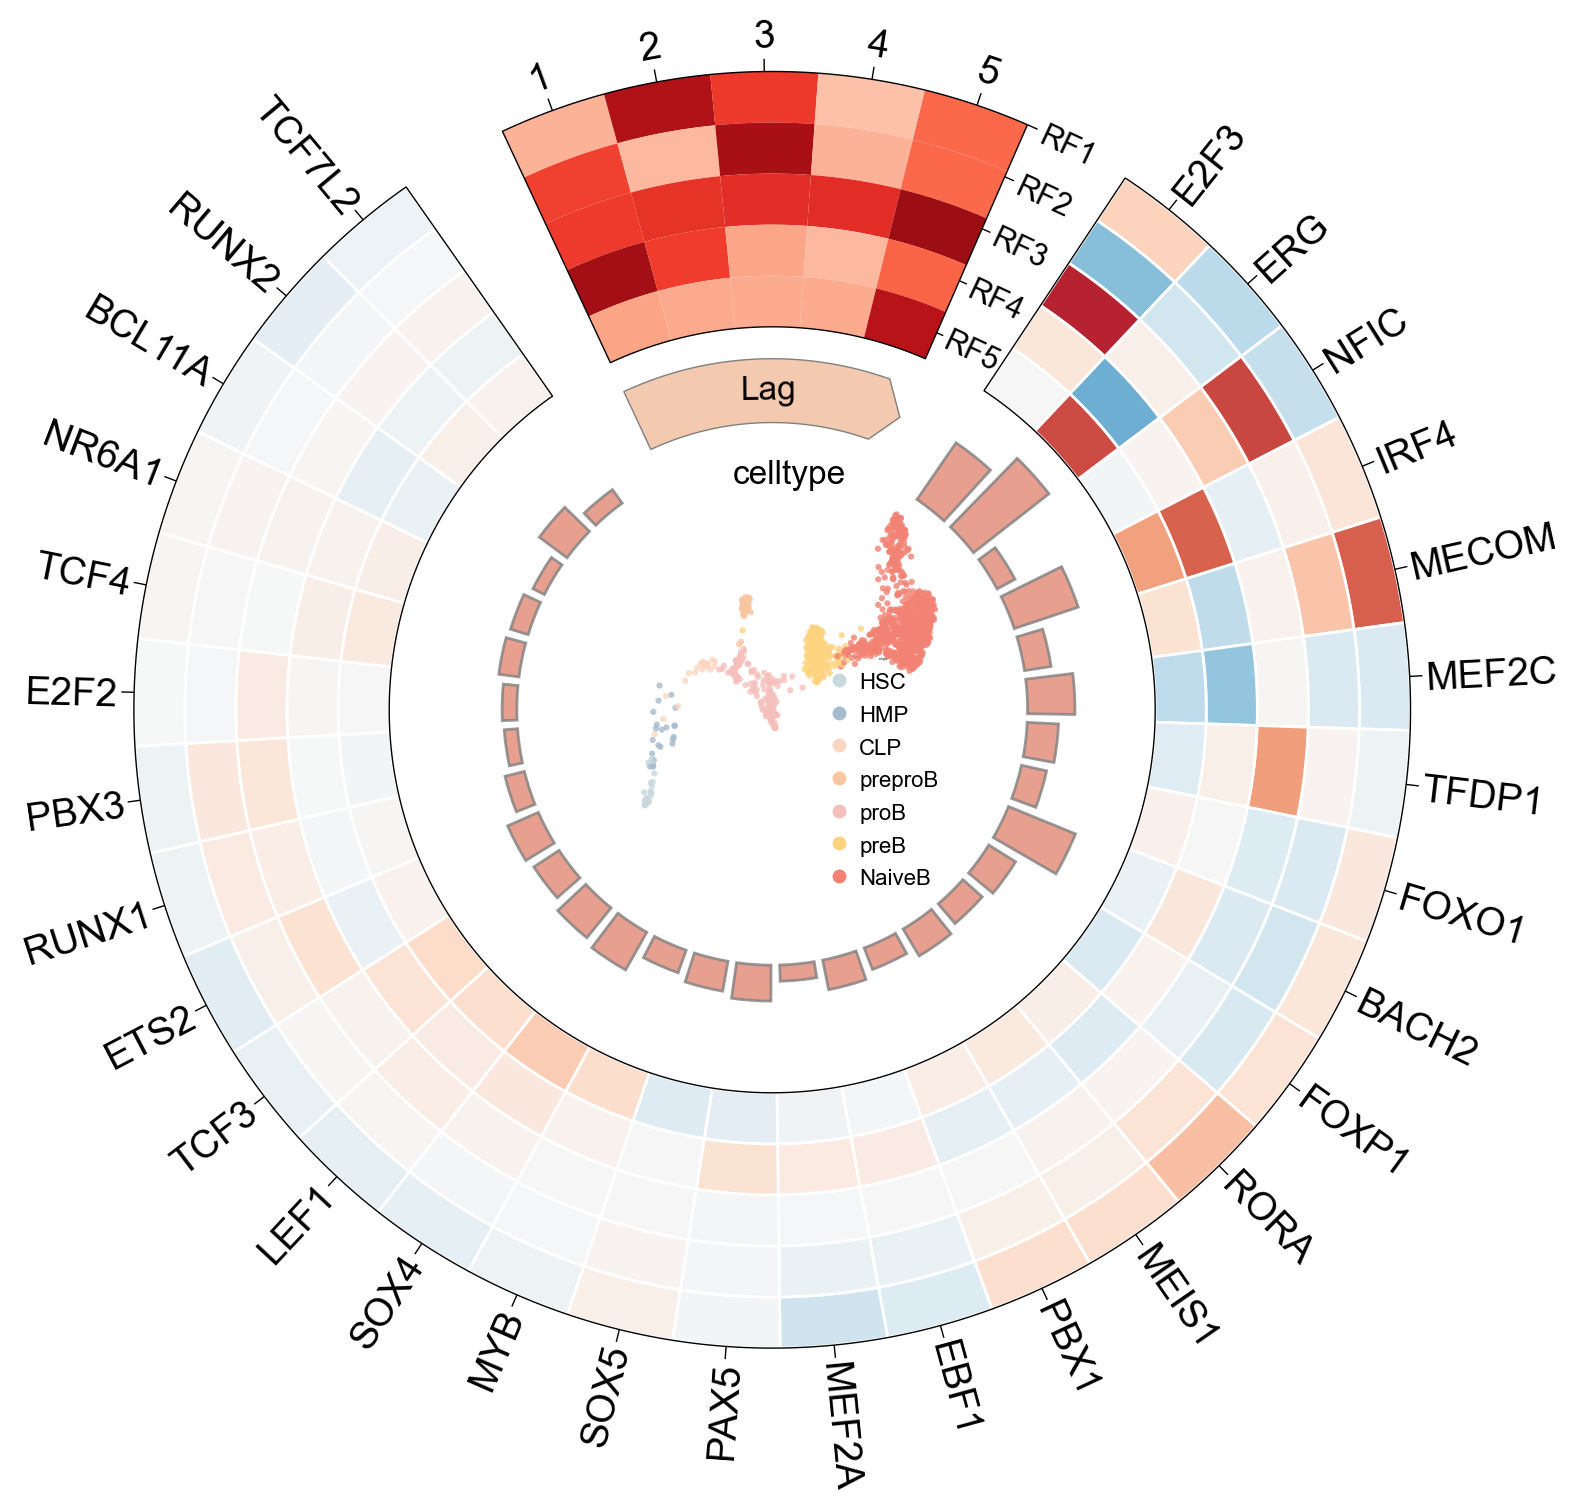

In [19]:
scm.pl.circosplot(
    gdata,
    top_tfs=30,
    cluster=True,
    colorbar=False,
    label_kws={"label_size": 14},
    embedding_key="X_umap",
    color_key="celltype",
    center_axes_rect=(0.40, 0.46, 0.20, 0.20)
)

### TF Loadings

The "TF loadings" represent the contribution score of each transcription factor to a given RegFactor module. We can visualize these scores to understand the composition of each module.

/home/chenxufeng/WorkSpace/Git-repos/scMagnify/src/scmagnify/plotting/_rankplot.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


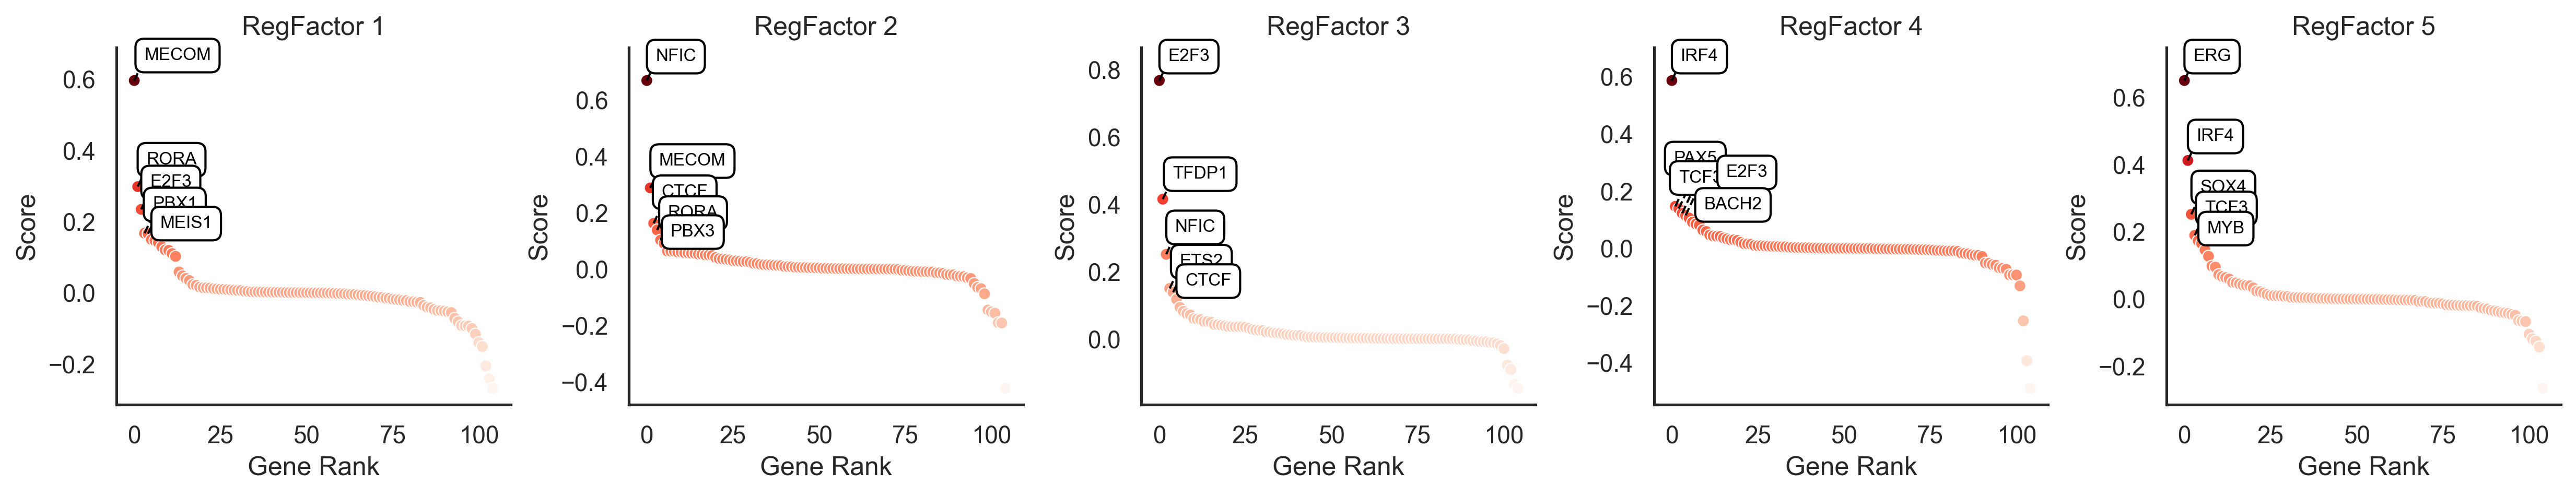

In [28]:
scm.pl.rankplot(
    gdata, 
    modal="RegFactor", 
    key="TF_loadings", 
    cmap="Reds", 
    n_top=5,
    ncols=5, 
    wspace=0.3,
    swap_df=True,
    figsize=(20, 3),
    show=True
)

/home/chenxufeng/WorkSpace/Git-repos/scMagnify/src/scmagnify/plotting/_barplot.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


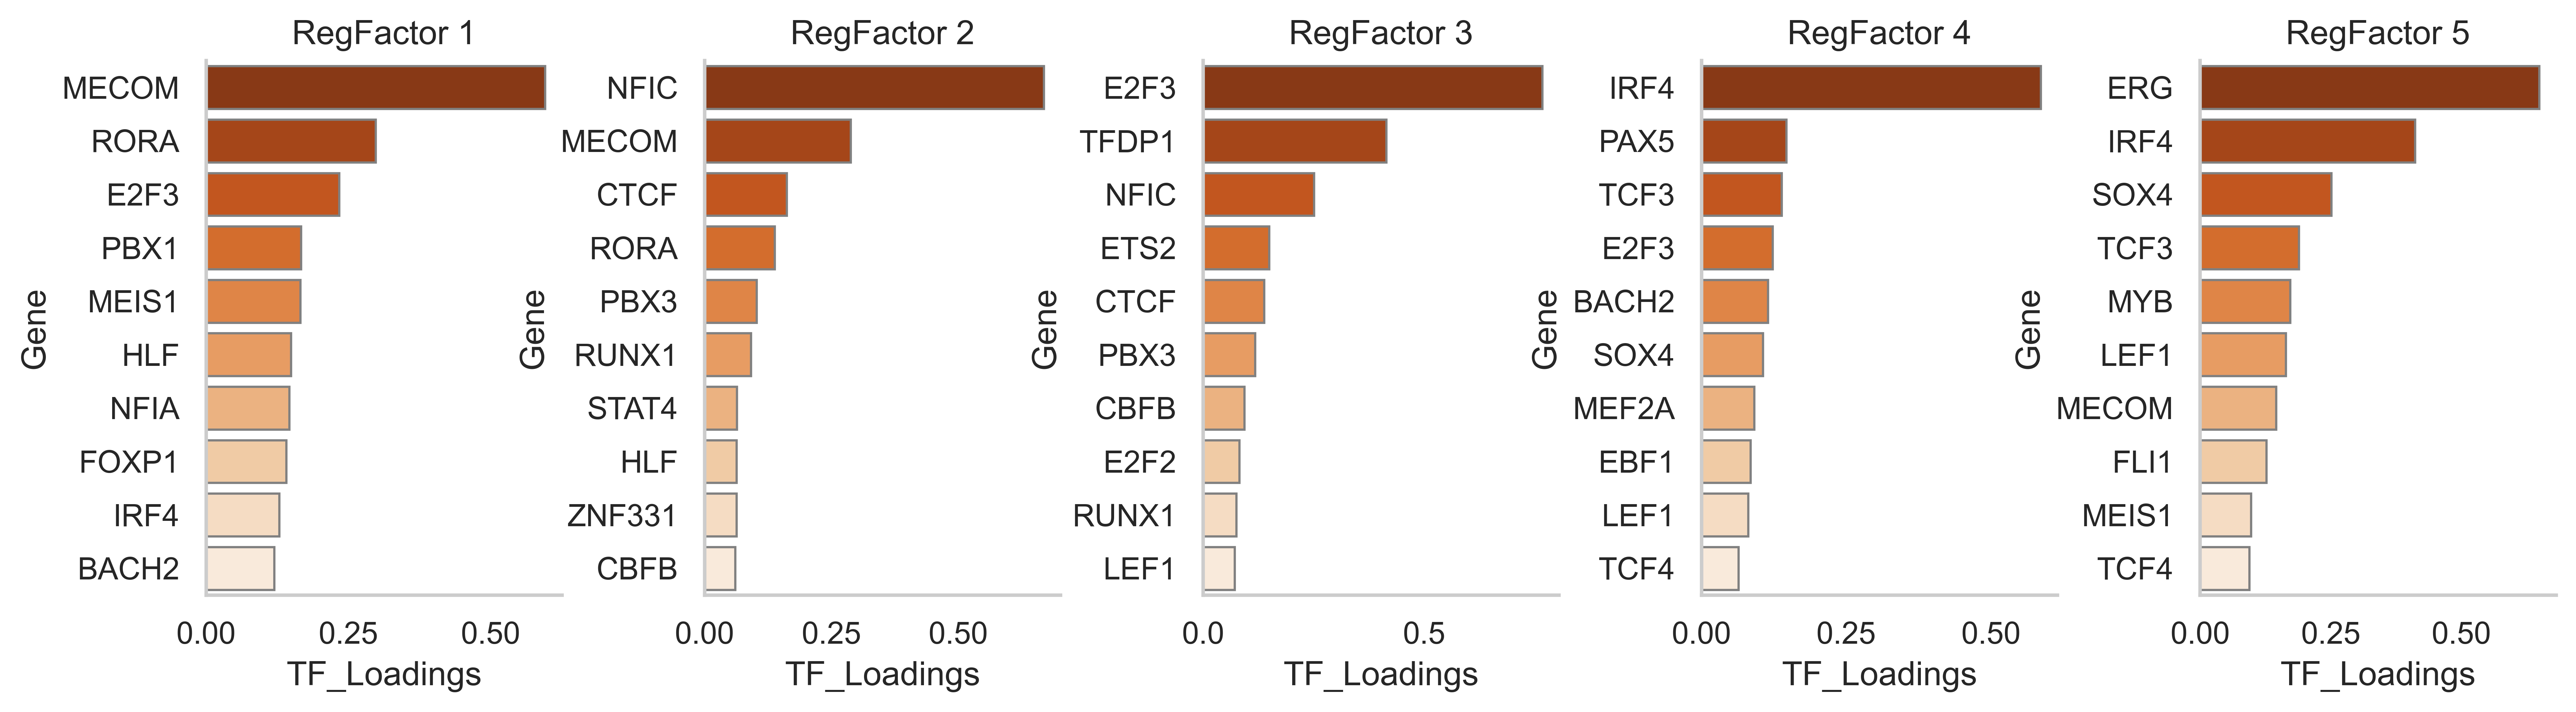

In [29]:
scm.pl.barplot(
    gdata,
    modal="RegFactor",
    key="TF_loadings",
    swap_df=True,
    n_top=10,
    ncols=5,
    cmap="Oranges_r",
    xlabel="TF_Loadings"
)

### RegFactor Activity

The activity of each RegFactor represents the combined regulatory influence of its constituent TFs. This activity is computed for each cell and stored in `gdata["RegFactor"]`. We can visualize these activities just like individual TF activities.

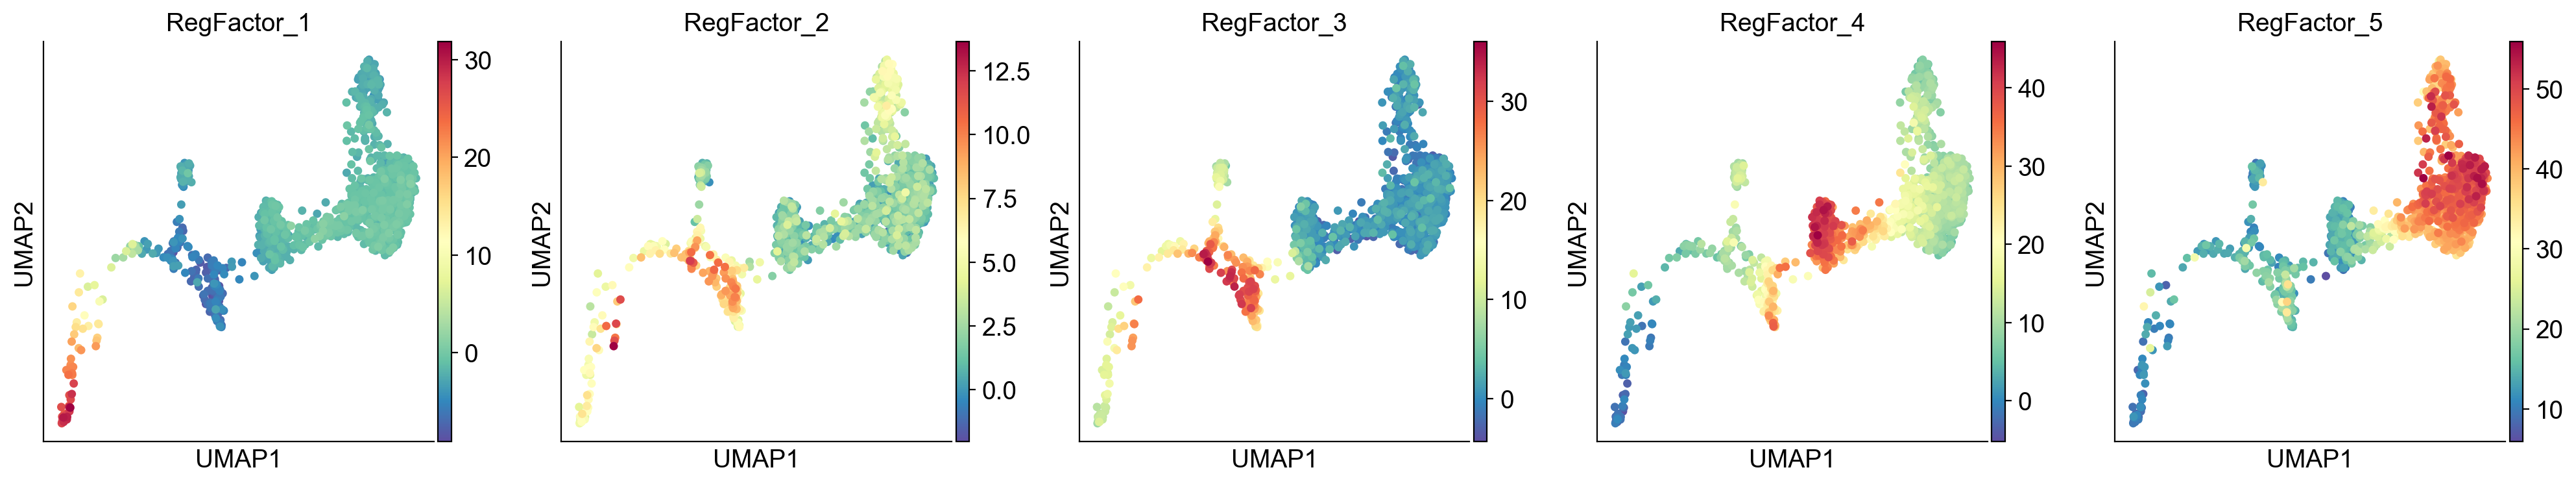

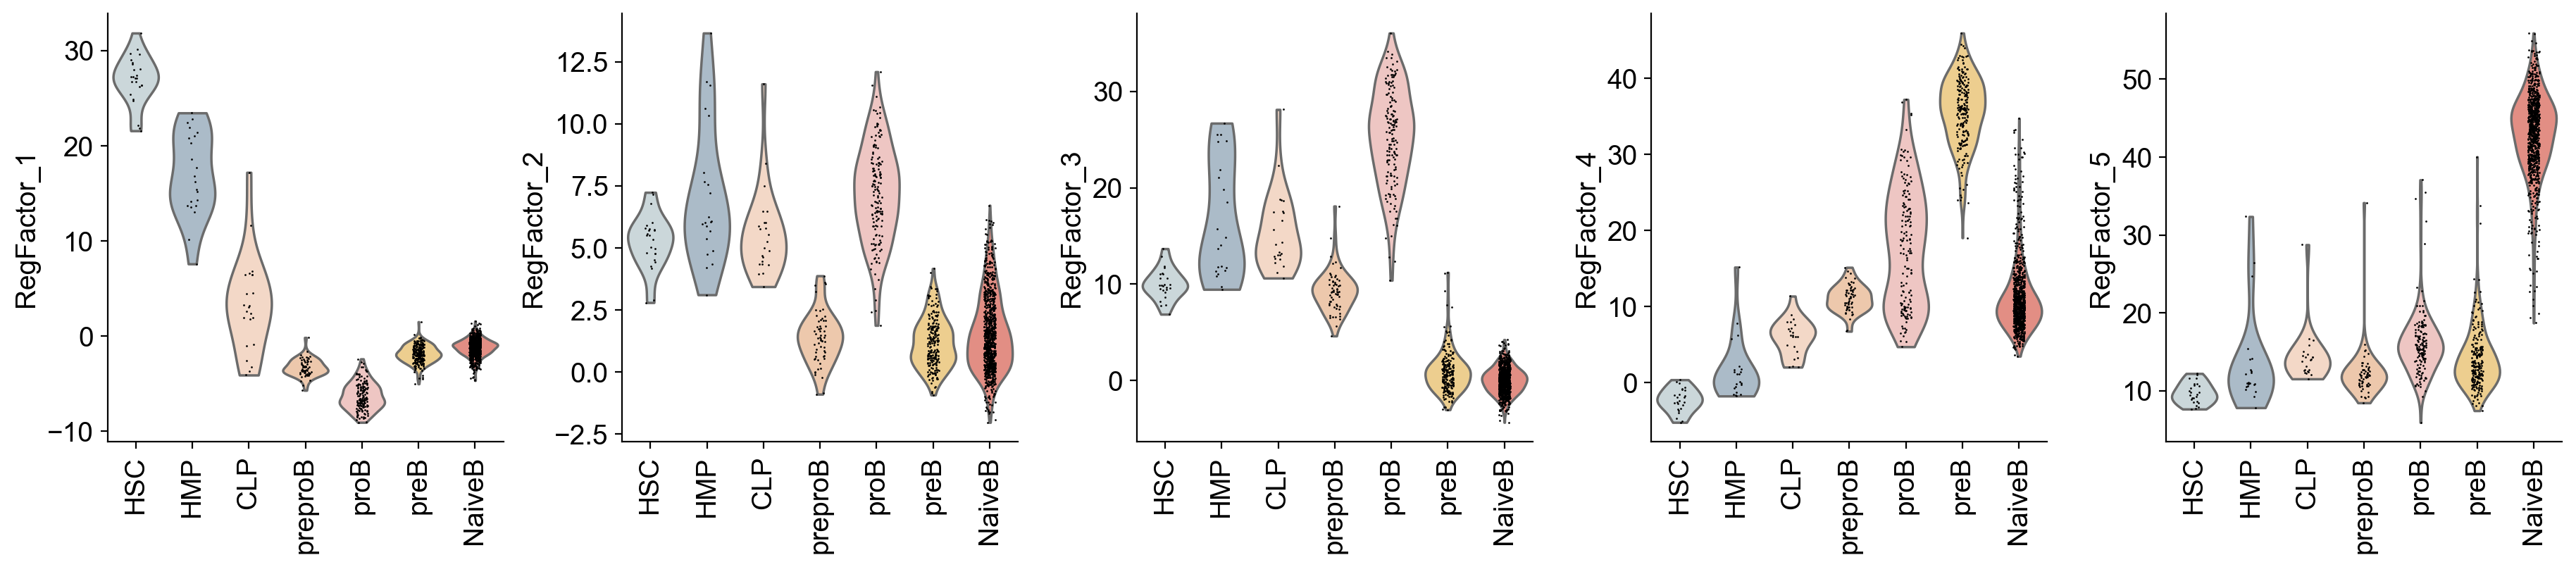

In [66]:
sc.pl.umap(gdata["RegFactor"], color=gdata["RegFactor"].var_names, ncols=5, cmap="Spectral_r")
sc.pl.violin(gdata["RegFactor"], groupby="celltype", keys=gdata["RegFactor"].var_names, rotation=90)

Finally, we can use `scm.pl.trendplot` to visualize the dynamic changes in RegFactor activity over pseudotime, allowing us to see when each regulatory module is turned "on" or "off" during the differentiation process.

/home/chenxufeng/WorkSpace/Git-repos/scMagnify/src/scmagnify/plotting/_trendplot.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


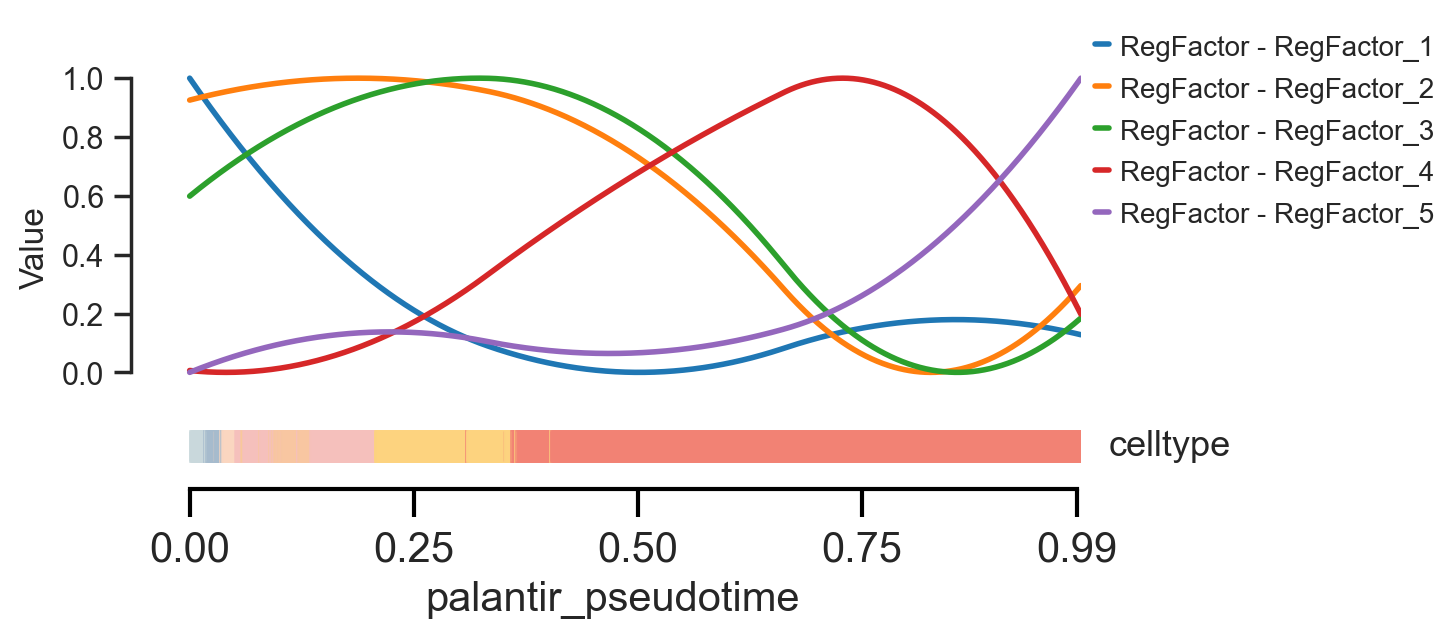

<Axes: xlabel='palantir_pseudotime', ylabel='Value'>

In [36]:
scm.pl.trendplot(
    gdata,
    var_dict = {
        "RegFactor_1": [("RegFactor", None)],
        "RegFactor_2": [("RegFactor", None)],
        "RegFactor_3": [("RegFactor", None)],
        "RegFactor_4": [("RegFactor", None)],
        "RegFactor_5": [("RegFactor", None)],
    },
    normalize = True,
    sortby = "palantir_pseudotime",
    col_color = ["celltype"],
    figsize=(6, 3),
    dpi=100,
    n_splines=5,
    show_tkey=False,
    show_stds=False,
)

## Funch Enrich

To understand the biological functions of the identified RegFactors, we can perform a functional enrichment analysis on their target gene sets. `scMagnify` implements a standard Over-Representation Analysis (ORA) for this purpose.

First, we can define a color palette for our RegFactors, which will be used in subsequent plots.

In [37]:
gdata.uns["regfactors_colors"] = ["#CED7DA", "#AFBAC9", "#E6C8C3", "#E6CF8C", "#D49284"]

In [38]:
from scmagnify.tools import FuncEnrich

Next, we initialize the {py:class}~scmagnify.tools.FuncEnrich object. We specify the gene set database to use—in this case, the `human MSigDB (v2025.1) gene symbols`. We then filter this comprehensive database to include only the "Gene Ontology Biological Process" (GOBP) terms.

In [39]:
enricher = FuncEnrich(gene_sets = "msigdb.v2025.1.Hs.symbols")
enricher.filter_genesets(pattern="GOBP")

INFO     Initializing FuncEnrich object.

INFO     Loading built-in gene set: msigdb.v2025.1.Hs.symbols from                                                 
         /home/chenxufeng/WorkSpace/Git-repos/scMagnify/src/scmagnify/data/genesets/msigdb.v2025.1.Hs.symbols.gmt

INFO     Successfully loaded 35134 gene sets with a total of 43351 unique gene symbols.

INFO     Filtering 35134 gene sets with pattern: 'GOBP'.

INFO     Filter applied. Kept 7583 of 35134 gene sets.

     RegFactor Gene Summary      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ RegFactor   ┃ Number of Genes ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ RegFactor_1 │             500 │
│ RegFactor_2 │             500 │
│ RegFactor_3 │             500 │
│ RegFactor_4 │             500 │
│ RegFactor_5 │             500 │
└─────────────┴─────────────────┘

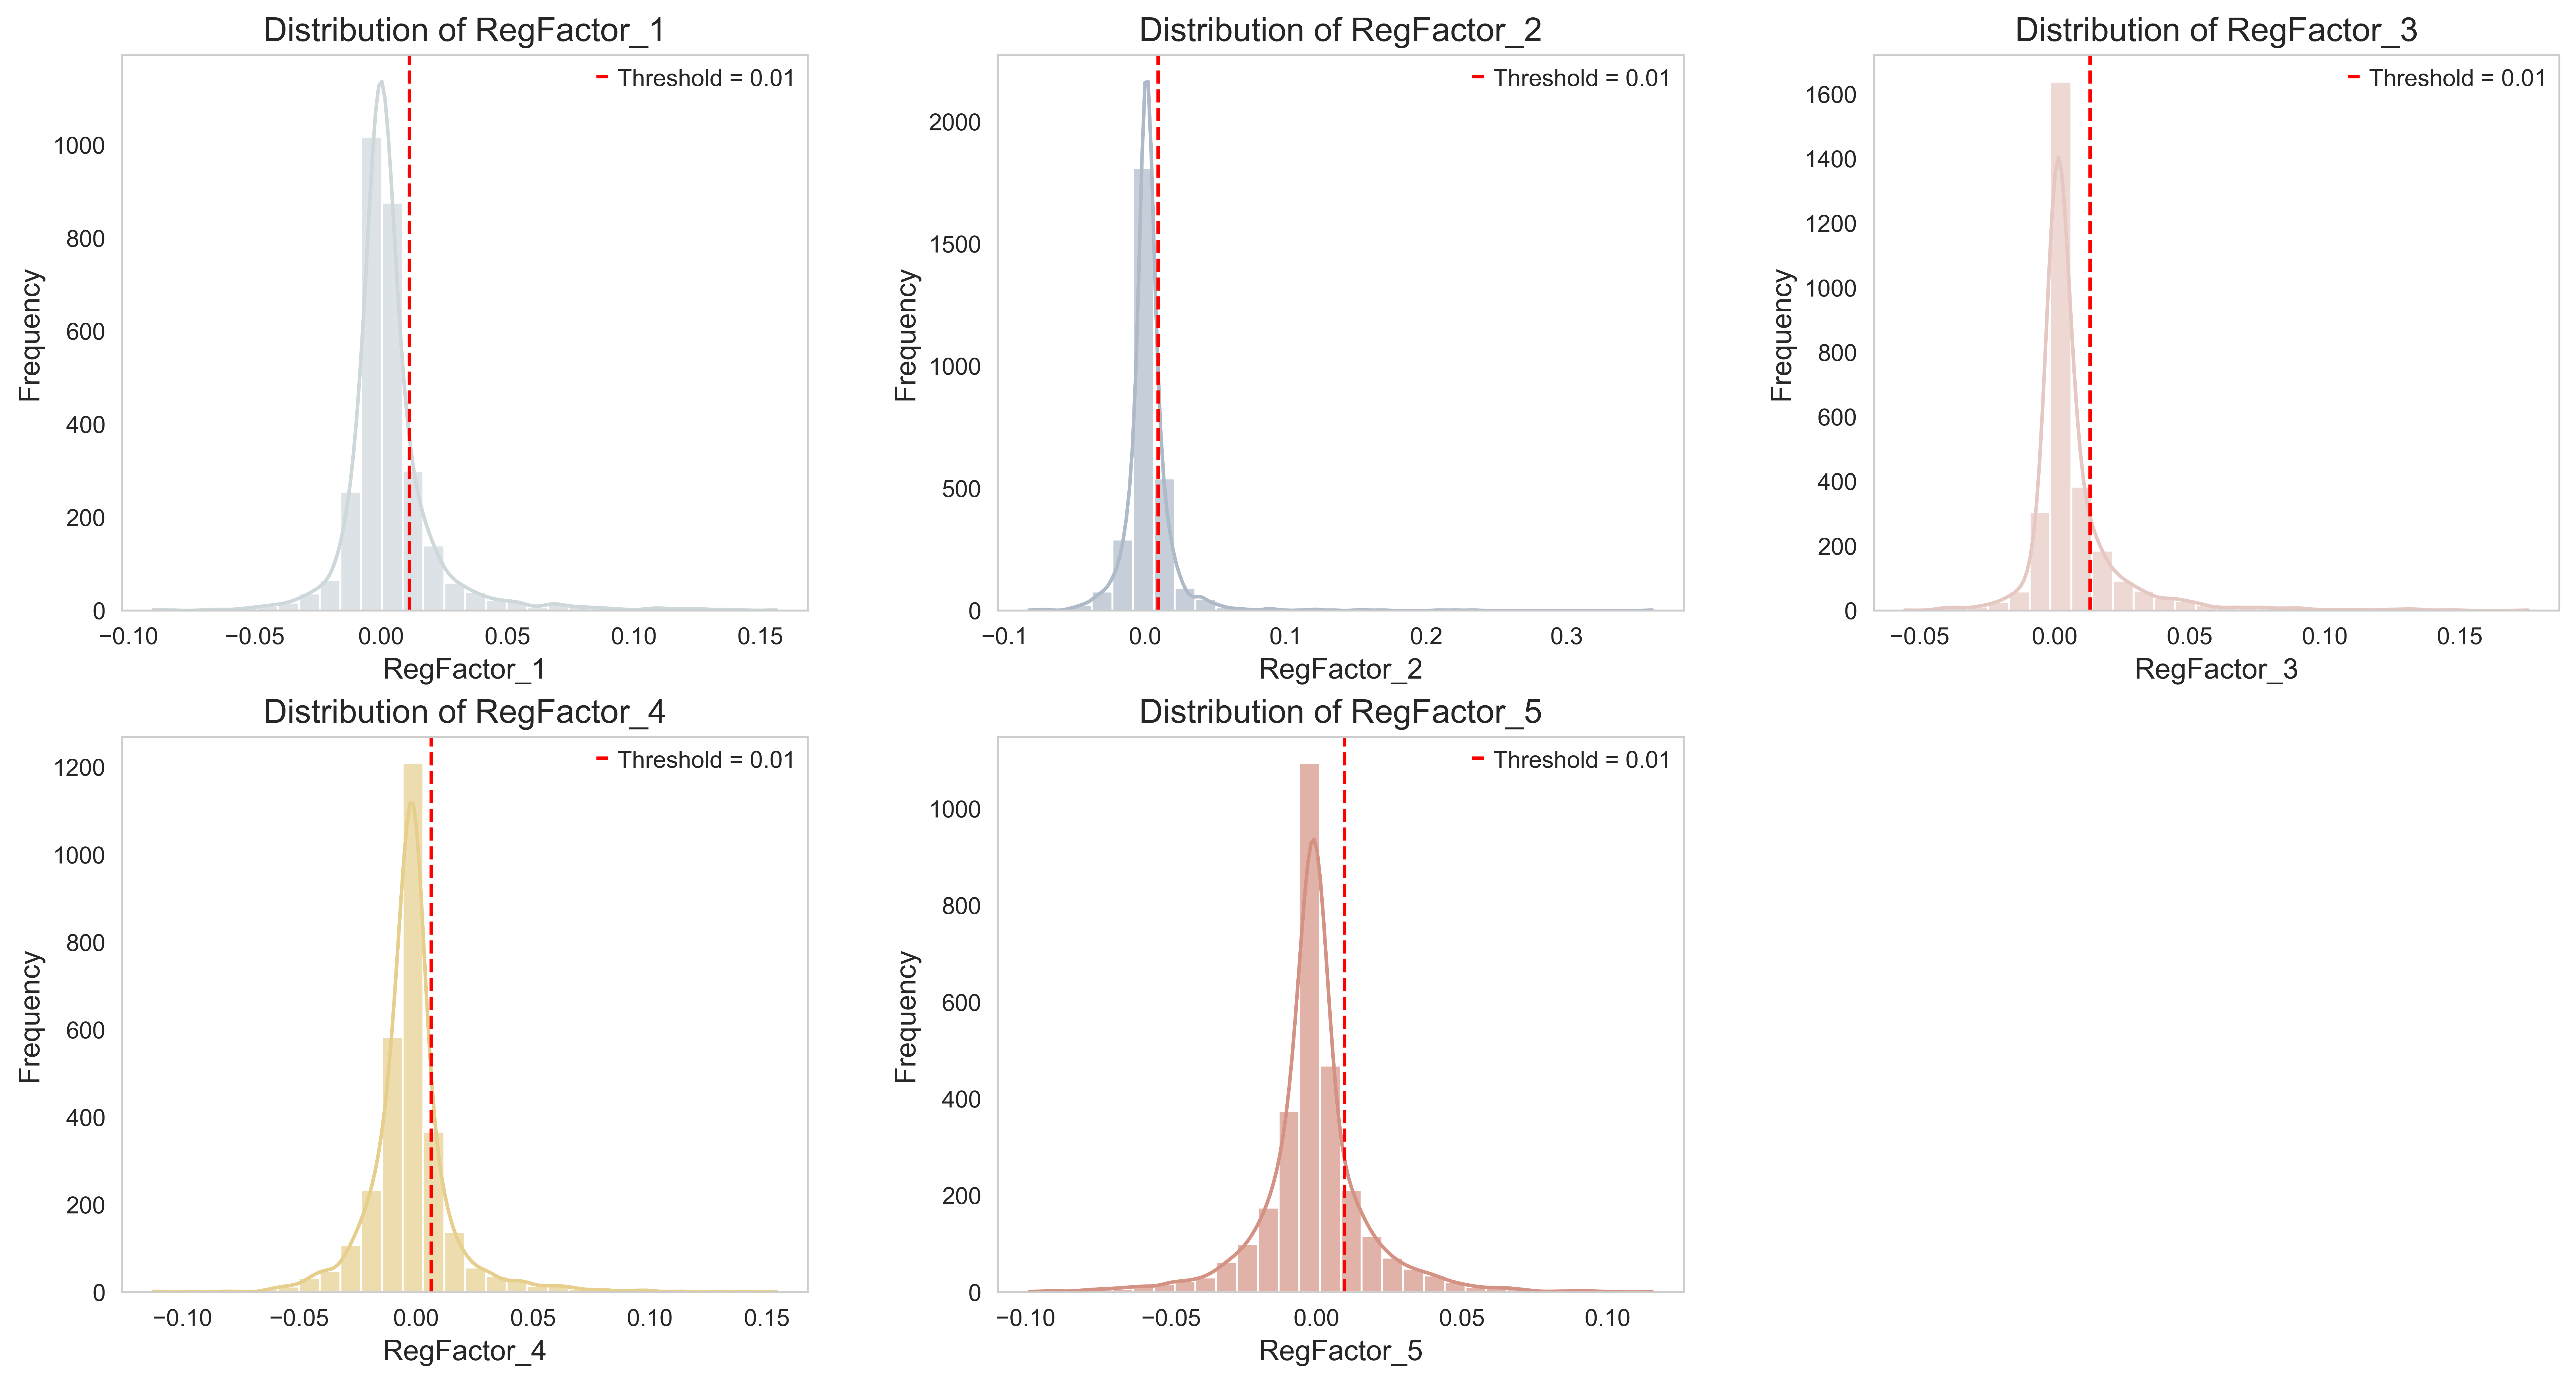

In [42]:
tg_dict = scm.tl.extract_regfactor_genes(
    gdata,
    mode = "TG",
    plot = True,
    n_top = 500,
)

INFO     Running ORA for regfactor: RegFactor_1

INFO     Starting ORA for a list of 500 genes.

INFO     Using a user-defined background size of 20000 genes.

                                     Top 10 Enriched Terms                                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Term                                               ┃ Overlap ┃ Combined score ┃ FDR p-value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ GOBP_SPHINGOLIPID_TRANSLOCATION                    │   4/5   │       4.34e+02 │    3.68e-04 │
│ GOBP_POSITIVE_REGULATION_OF_FC_RECEPTOR_MEDIATED_… │   3/6   │       1.76e+02 │    1.31e-02 │
│ GOBP_EMBRYONIC_HEMOPOIESIS                         │  7/24   │       1.67e+02 │    3.23e-04 │
│ GOBP_PLATELET_ACTIVATING_FACTOR_METABOLIC_PROCESS  │   3/8   │       1.18e+02 │    2.59e-02 │
│ GOBP_NEGATIVE_REGULATION_OF_SMOOTH_MUSCLE_CONTRAC… │  4/14   │       1.01e+02 │    1.38e-02 │
│ GOBP_PRIMITIVE_HEMOPOIESIS                         │   3/9   │       1.00e+02 │    3.18e-02 │
│ GOBP_LYMPHOCYTE_DIFFERENTIATION                    │ 39/440  │       9.70e+01 │    3.22e-08 │
│ GOBP_POSITIVE_REGULATION_OF_MAST_CELL_PROLIFERATI… │   2/5   │       9.35e+01 │    9.62e-02 │
│ GOBP_NUCLEAR_MIGRATION_ALONG_MICROTUBULE           │   2/5   │       9.35e+01 │    9.62e-02 │
│ GOBP_REGULATION_OF_CELL_DIFFERENTIATION_INVOLVED_… │   2/5   │       9.35e+01 │    9.62e-02 │
└────────────────────────────────────────────────────┴─────────┴────────────────┴─────────────┘

/home/chenxufeng/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


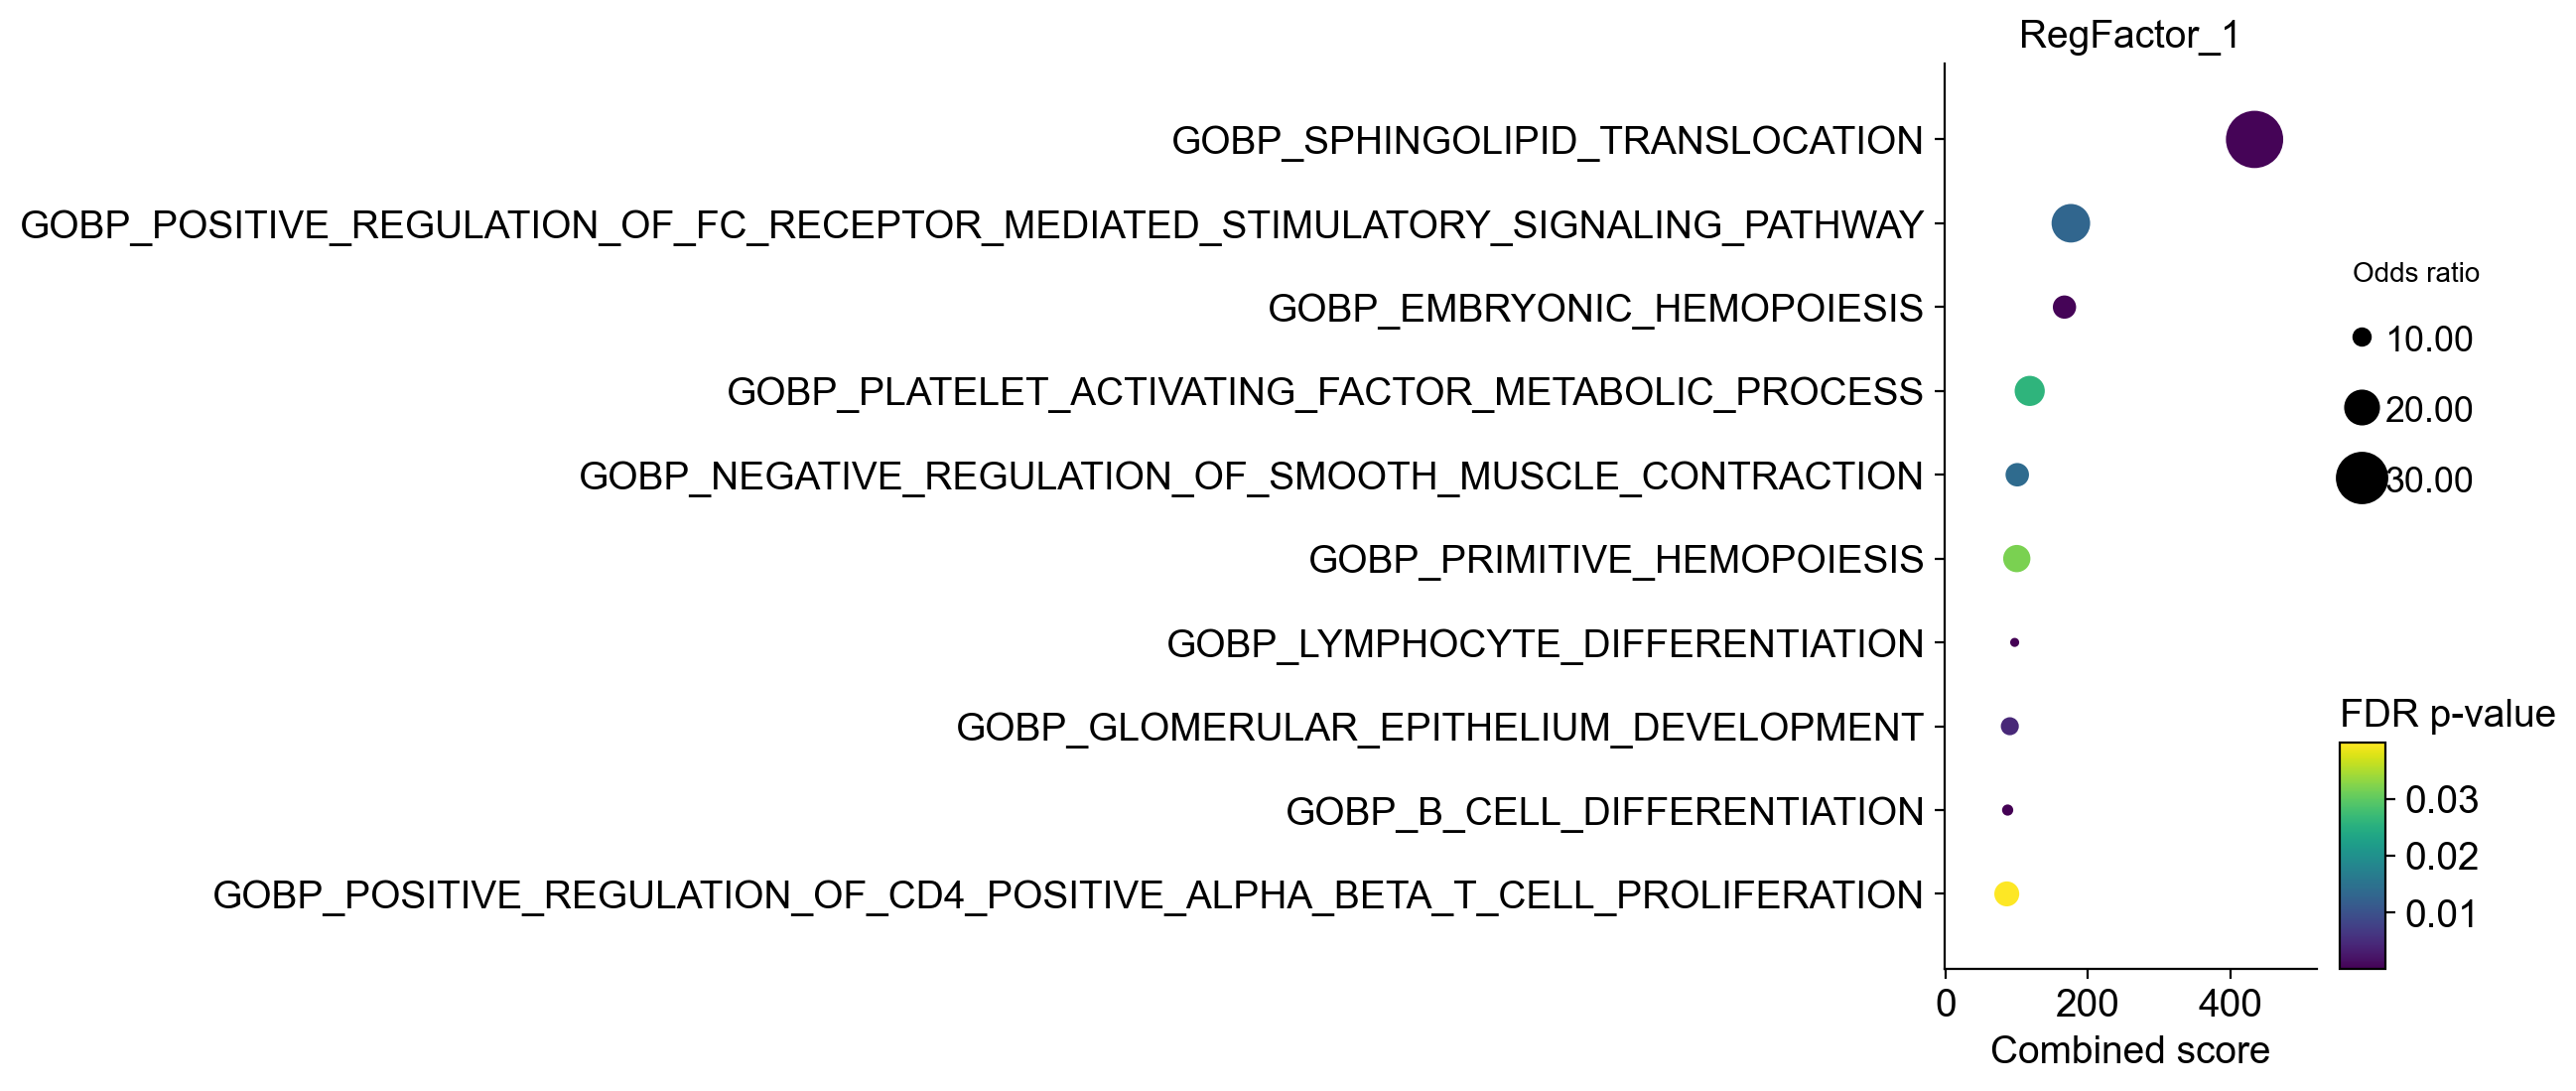

INFO     Running ORA for regfactor: RegFactor_2

INFO     Starting ORA for a list of 500 genes.

INFO     Using a user-defined background size of 20000 genes.

                                     Top 10 Enriched Terms                                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Term                                               ┃ Overlap ┃ Combined score ┃ FDR p-value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ GOBP_POSITIVE_REGULATION_OF_FC_RECEPTOR_MEDIATED_… │   4/6   │       3.37e+02 │    6.16e-04 │
│ GOBP_REGULATION_OF_FC_RECEPTOR_MEDIATED_STIMULATO… │  4/11   │       1.43e+02 │    5.43e-03 │
│ GOBP_ESTABLISHMENT_OF_MITOTIC_SISTER_CHROMATID_CO… │   3/7   │       1.42e+02 │    1.52e-02 │
│ GOBP_KINETOCHORE_ORGANIZATION                      │  6/21   │       1.41e+02 │    7.85e-04 │
│ GOBP_KINETOCHORE_ASSEMBLY                          │  5/17   │       1.27e+02 │    2.72e-03 │
│ GOBP_MAINTENANCE_OF_LENS_TRANSPARENCY              │   3/8   │       1.18e+02 │    2.12e-02 │
│ GOBP_NUCLEAR_BODY_ORGANIZATION                     │  5/18   │       1.16e+02 │    3.39e-03 │
│ GOBP_THYMIC_T_CELL_SELECTION                       │  6/24   │       1.15e+02 │    1.63e-03 │
│ GOBP_NEGATIVE_T_CELL_SELECTION                     │  4/13   │       1.12e+02 │    9.04e-03 │
│ GOBP_MITOTIC_SISTER_CHROMATID_COHESION             │  7/31   │       1.12e+02 │    7.84e-04 │
└────────────────────────────────────────────────────┴─────────┴────────────────┴─────────────┘

/home/chenxufeng/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


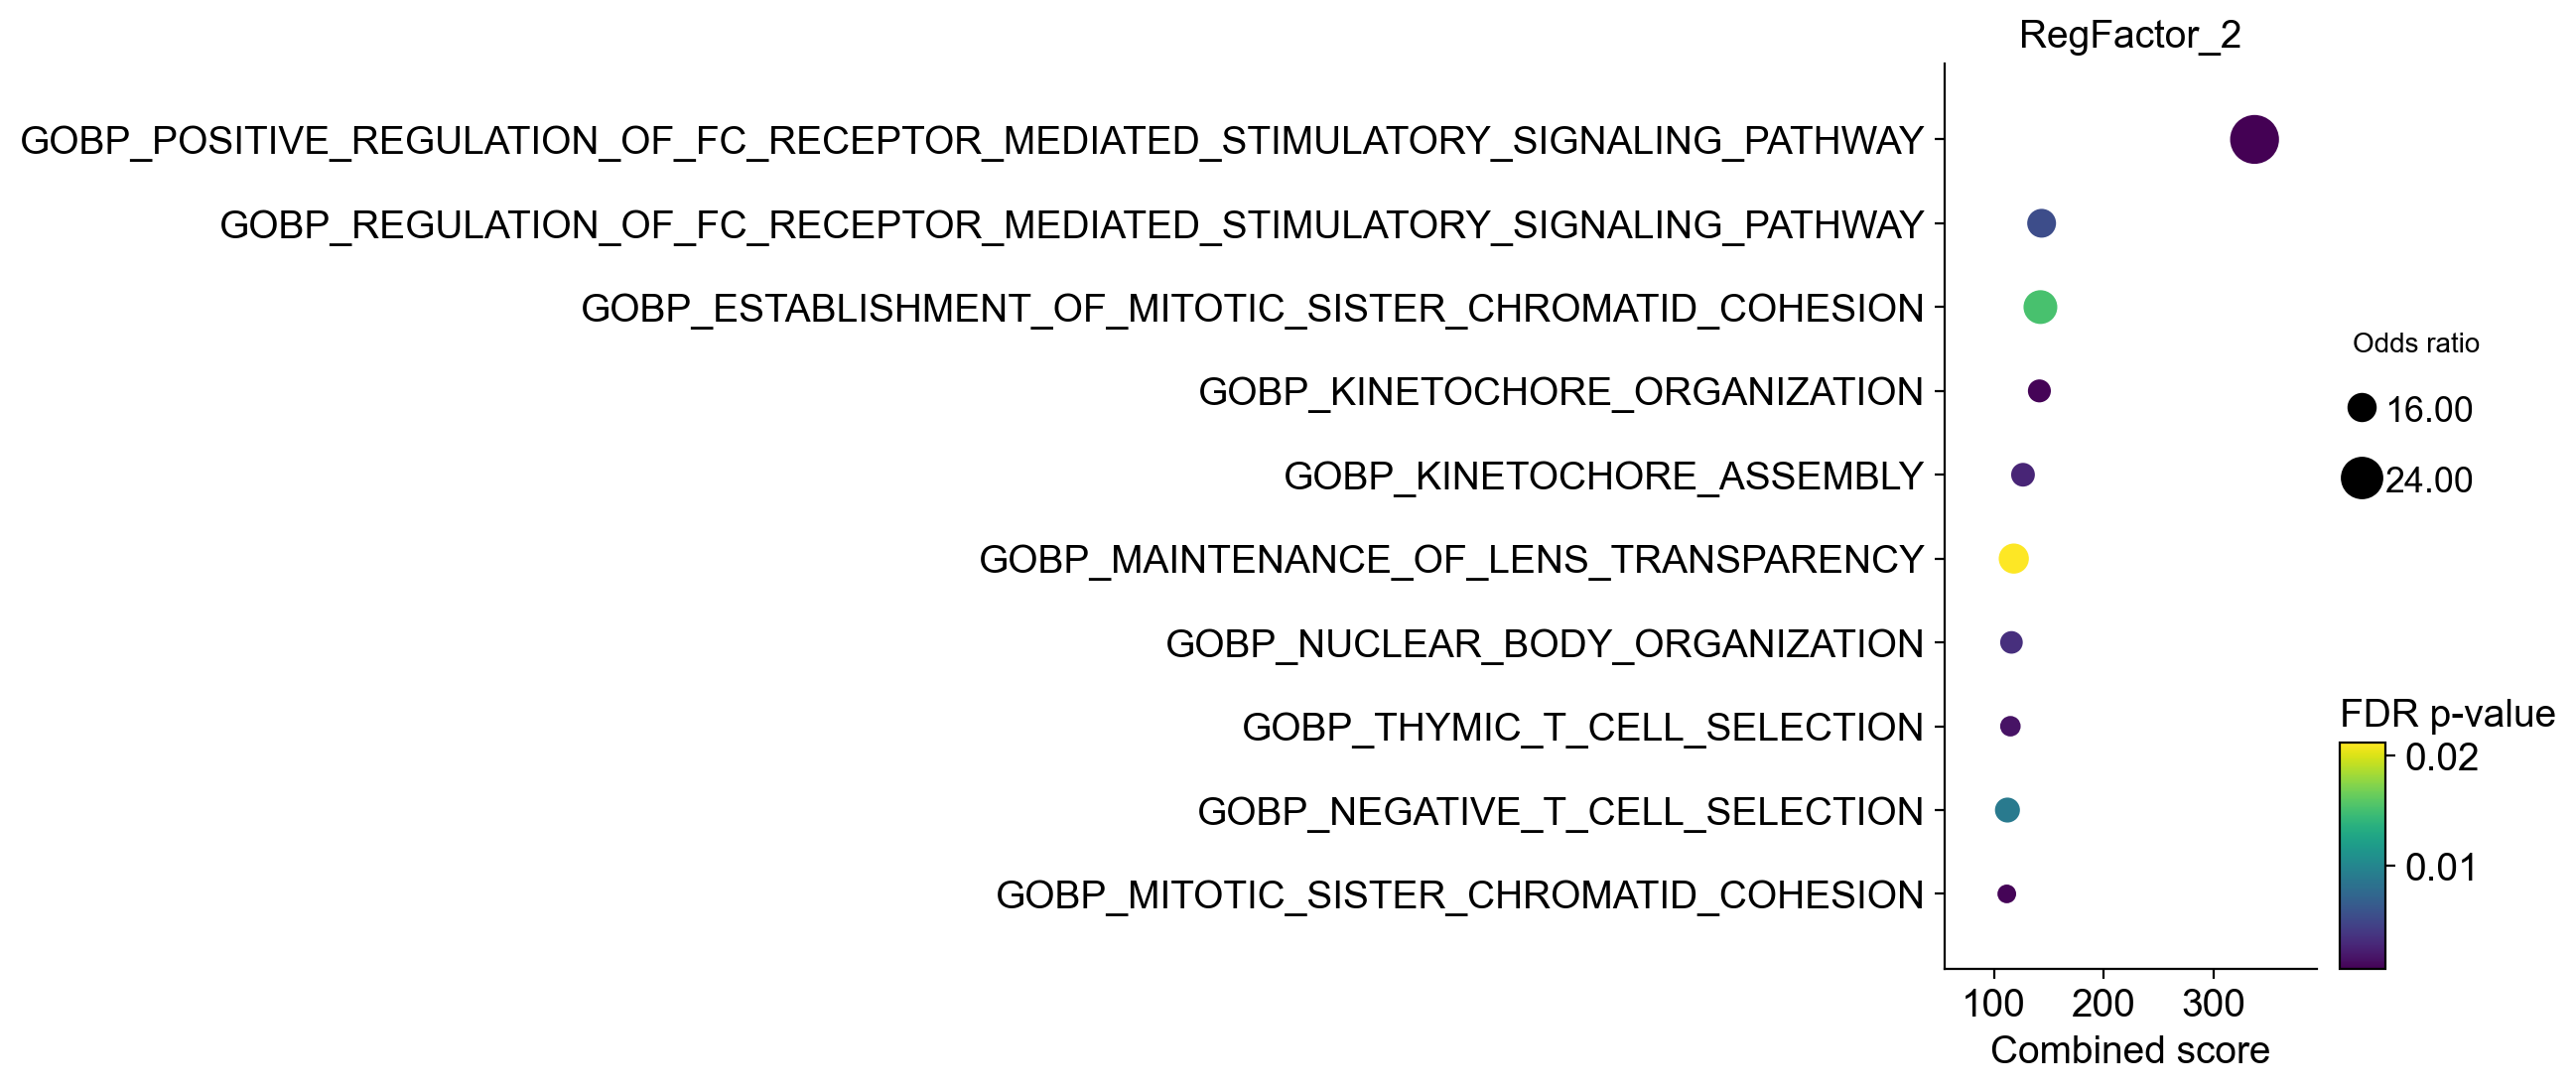

INFO     Running ORA for regfactor: RegFactor_3

INFO     Starting ORA for a list of 500 genes.

INFO     Using a user-defined background size of 20000 genes.

                                     Top 10 Enriched Terms                                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Term                                               ┃ Overlap  ┃ Combined score ┃ FDR p-value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ GOBP_CRD_MEDIATED_MRNA_STABILIZATION               │   5/11   │       2.40e+02 │    2.54e-04 │
│ GOBP_CELL_CYCLE_PROCESS                            │ 105/1348 │       2.17e+02 │    1.29e-22 │
│ GOBP_POSITIVE_REGULATION_OF_CYTOPLASMIC_TRANSLATI… │   6/17   │       1.95e+02 │    1.65e-04 │
│ GOBP_MITOTIC_CELL_CYCLE_PROCESS                    │  70/783  │       1.85e+02 │    1.47e-17 │
│ GOBP_POSITIVE_REGULATION_OF_PROTEIN_LOCALIZATION_… │   3/6    │       1.76e+02 │    8.46e-03 │
│ GOBP_POSITIVE_REGULATION_OF_MAINTENANCE_OF_SISTER… │   3/6    │       1.76e+02 │    8.46e-03 │
│ GOBP_CELL_CYCLE                                    │ 116/1705 │       1.74e+02 │    1.08e-20 │
│ GOBP_MITOTIC_CELL_CYCLE                            │  75/931  │       1.57e+02 │    1.75e-16 │
│ GOBP_POSITIVE_REGULATION_OF_CELL_CYCLE_PROCESS     │  33/275  │       1.54e+02 │    2.72e-11 │
│ GOBP_POSITIVE_REGULATION_OF_CELL_CYCLE             │  38/346  │       1.49e+02 │    8.71e-12 │
└────────────────────────────────────────────────────┴──────────┴────────────────┴─────────────┘

/home/chenxufeng/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


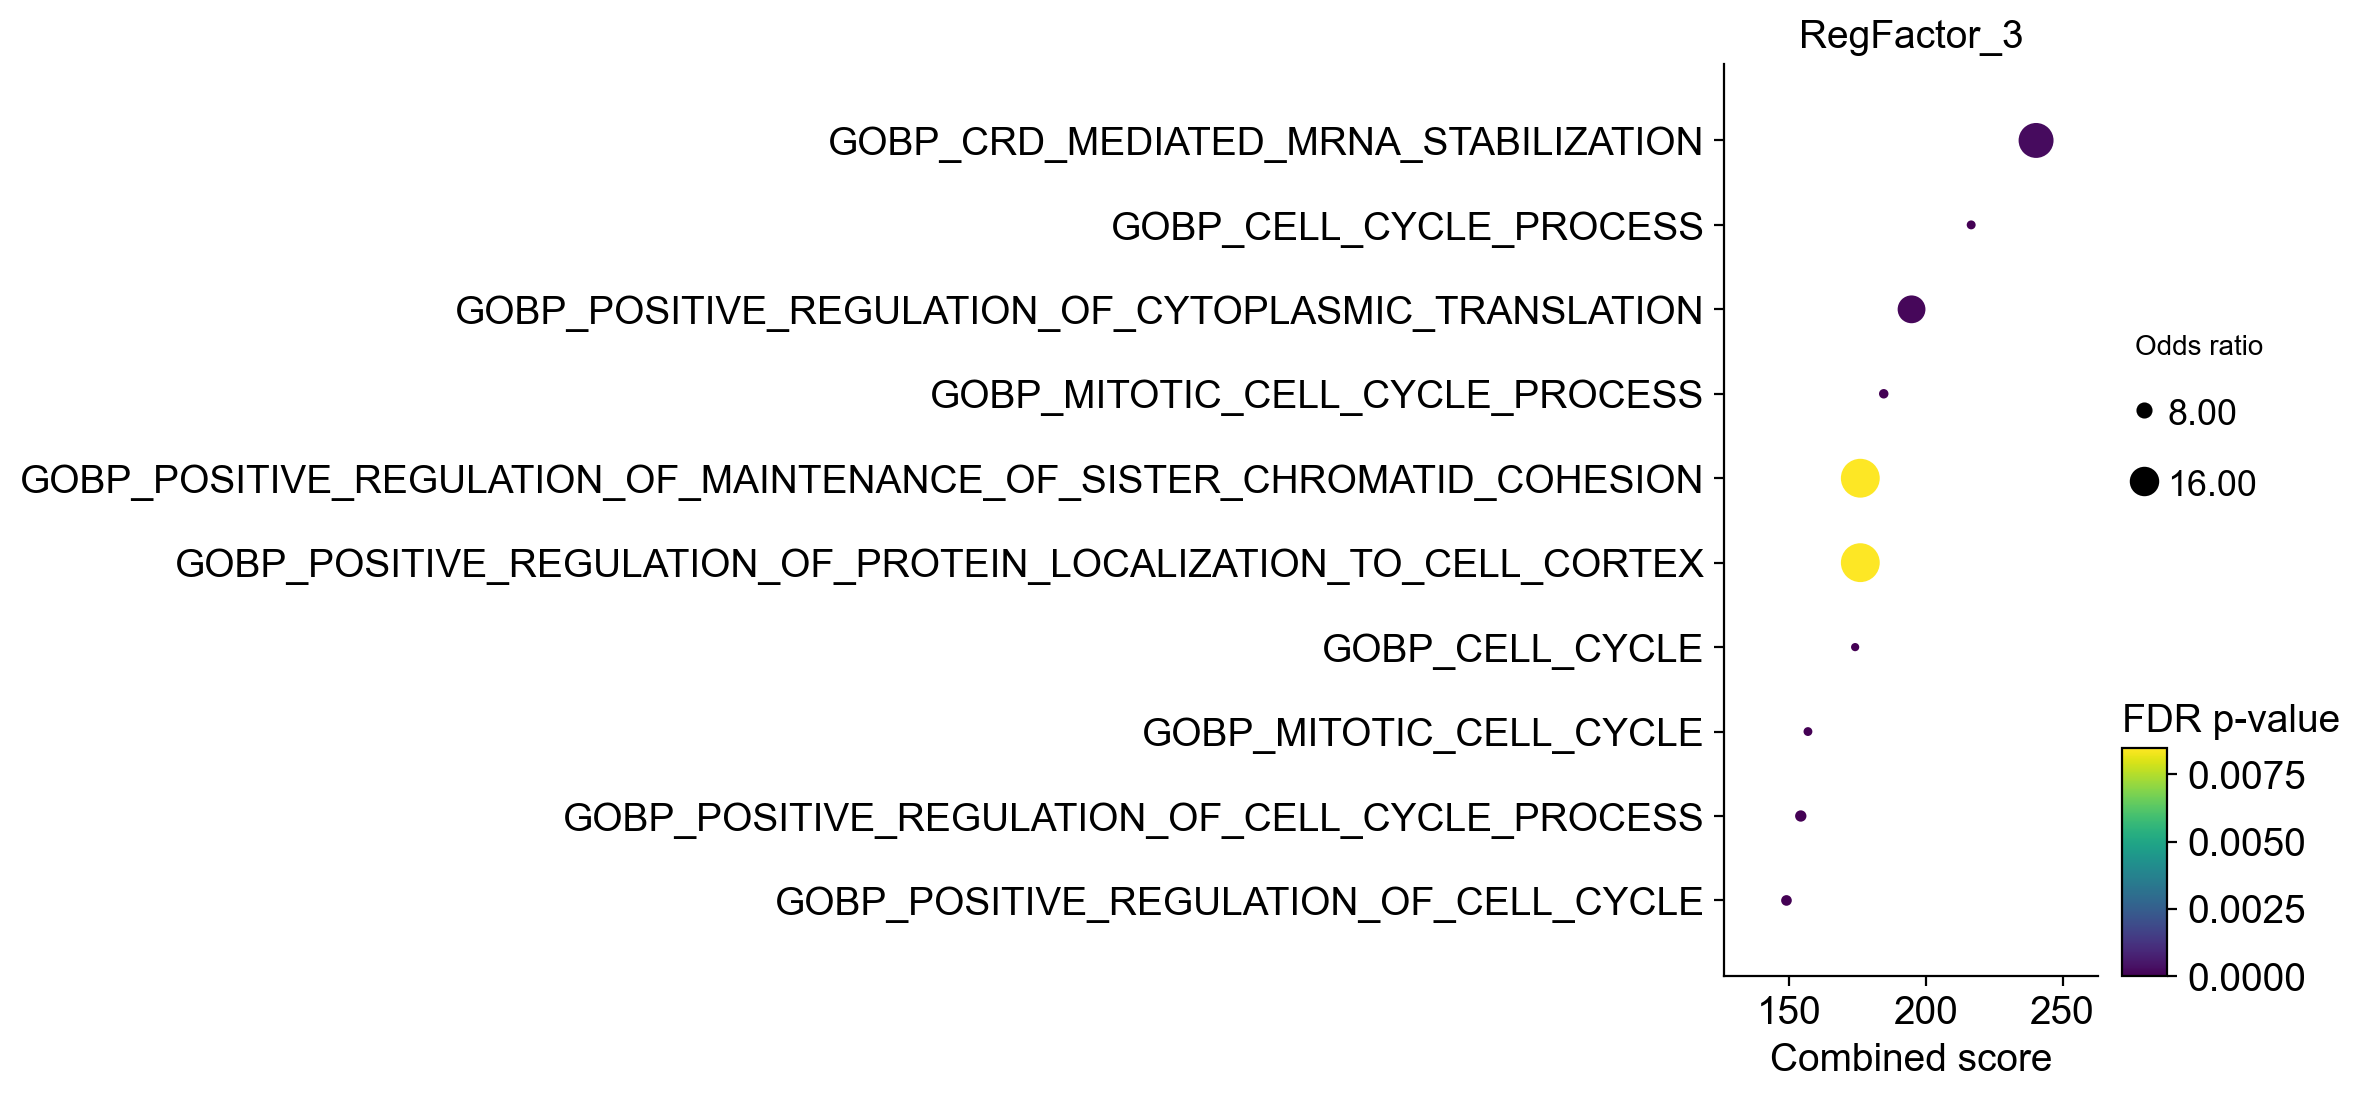

INFO     Running ORA for regfactor: RegFactor_4

INFO     Starting ORA for a list of 500 genes.

INFO     Using a user-defined background size of 20000 genes.

                                     Top 10 Enriched Terms                                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Term                                               ┃ Overlap ┃ Combined score ┃ FDR p-value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ GOBP_DNA_TOPOLOGICAL_CHANGE                        │  5/10   │       2.76e+02 │    1.54e-04 │
│ GOBP_DNA_CONFORMATION_CHANGE                       │  6/18   │       1.79e+02 │    2.27e-04 │
│ GOBP_POSITIVE_REGULATION_OF_FC_RECEPTOR_MEDIATED_… │   3/6   │       1.76e+02 │    7.69e-03 │
│ GOBP_POSITIVE_REGULATION_OF_GAMMA_DELTA_T_CELL_AC… │  4/11   │       1.43e+02 │    3.62e-03 │
│ GOBP_B_CELL_RECEPTOR_SIGNALING_PATHWAY             │  14/78  │       1.42e+02 │    1.64e-06 │
│ GOBP_REGULATION_OF_NUCLEOTIDE_EXCISION_REPAIR      │  7/29   │       1.24e+02 │    3.39e-04 │
│ GOBP_REGULATION_OF_CELLULAR_PH_REDUCTION           │   3/8   │       1.18e+02 │    1.61e-02 │
│ GOBP_POSITIVE_REGULATION_OF_CHROMOSOME_CONDENSATI… │   3/8   │       1.18e+02 │    1.61e-02 │
│ GOBP_DNA_GEOMETRIC_CHANGE                          │   3/8   │       1.18e+02 │    1.61e-02 │
│ GOBP_B_CELL_DIFFERENTIATION                        │ 20/149  │       1.17e+02 │    2.82e-07 │
└────────────────────────────────────────────────────┴─────────┴────────────────┴─────────────┘

/home/chenxufeng/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


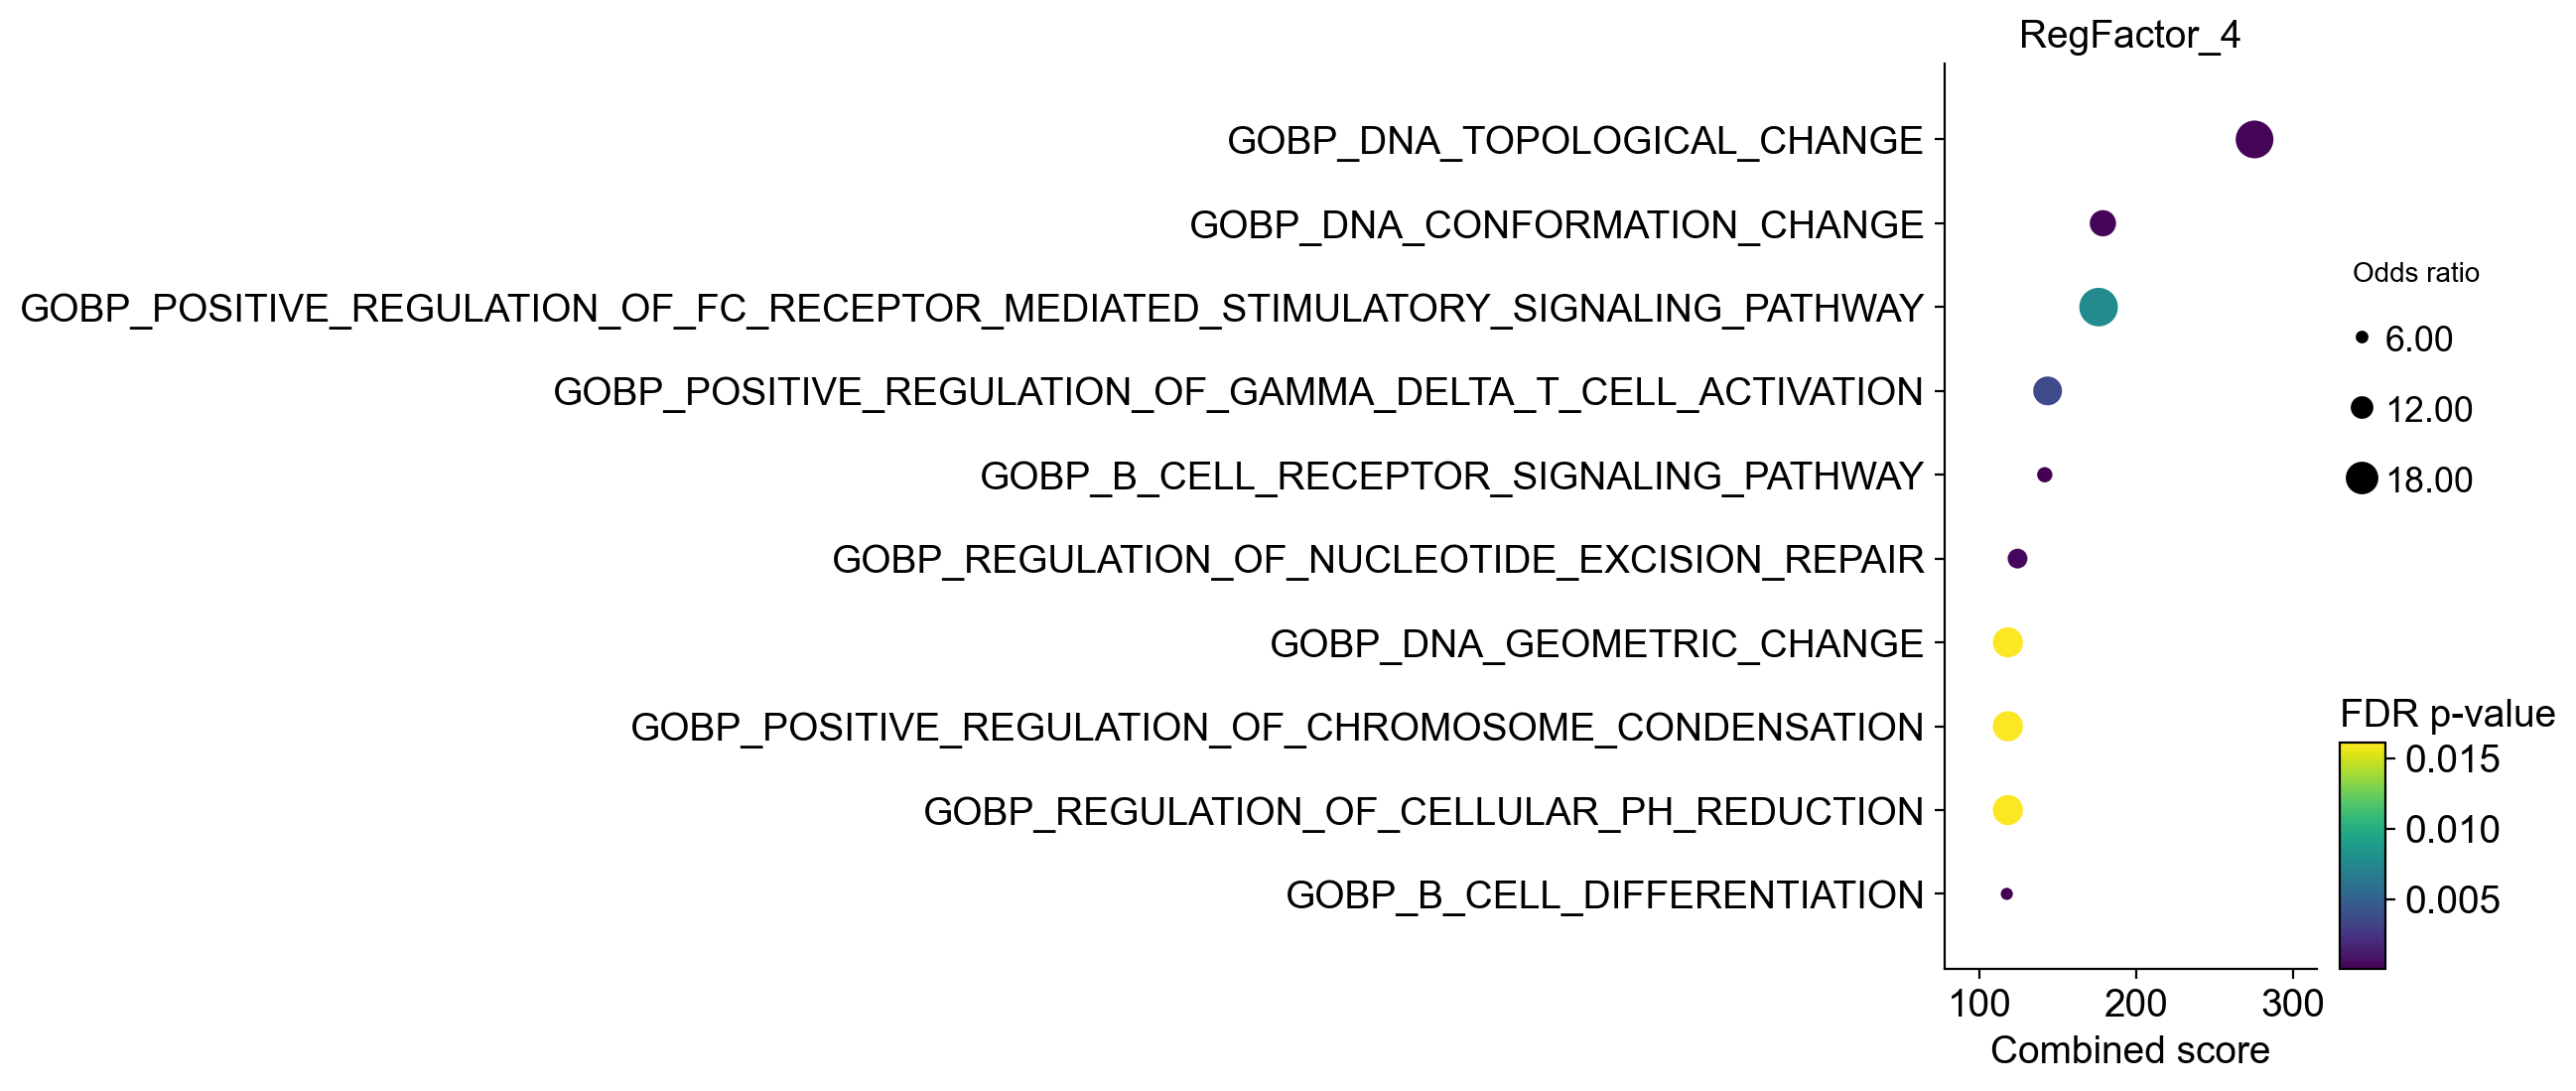

INFO     Running ORA for regfactor: RegFactor_5

INFO     Starting ORA for a list of 500 genes.

INFO     Using a user-defined background size of 20000 genes.

                                     Top 10 Enriched Terms                                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Term                                               ┃ Overlap ┃ Combined score ┃ FDR p-value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ GOBP_B_CELL_RECEPTOR_SIGNALING_PATHWAY             │  23/78  │       5.20e+02 │    8.95e-16 │
│ GOBP_PEPTIDE_ANTIGEN_ASSEMBLY_WITH_MHC_CLASS_II_P… │  8/16   │       4.24e+02 │    1.64e-07 │
│ GOBP_PEPTIDE_ANTIGEN_ASSEMBLY_WITH_MHC_PROTEIN_CO… │  8/21   │       2.83e+02 │    1.64e-06 │
│ GOBP_ANTIGEN_RECEPTOR_MEDIATED_SIGNALING_PATHWAY   │ 34/214  │       2.70e+02 │    3.64e-15 │
│ GOBP_REGULATION_OF_B_CELL_PROLIFERATION            │  16/68  │       2.53e+02 │    1.06e-09 │
│ GOBP_LYMPHOCYTE_ACTIVATION                         │ 80/846  │       2.44e+02 │    1.47e-21 │
│ GOBP_POSITIVE_REGULATION_OF_B_CELL_PROLIFERATION   │  12/47  │       2.21e+02 │    1.33e-07 │
│ GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EXOGE… │  11/41  │       2.20e+02 │    3.28e-07 │
│ GOBP_REGULATION_OF_B_CELL_RECEPTOR_SIGNALING_PATH… │  8/25   │       2.17e+02 │    6.51e-06 │
│ GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EXOGE… │  9/31   │       2.08e+02 │    3.05e-06 │
└────────────────────────────────────────────────────┴─────────┴────────────────┴─────────────┘

/home/chenxufeng/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


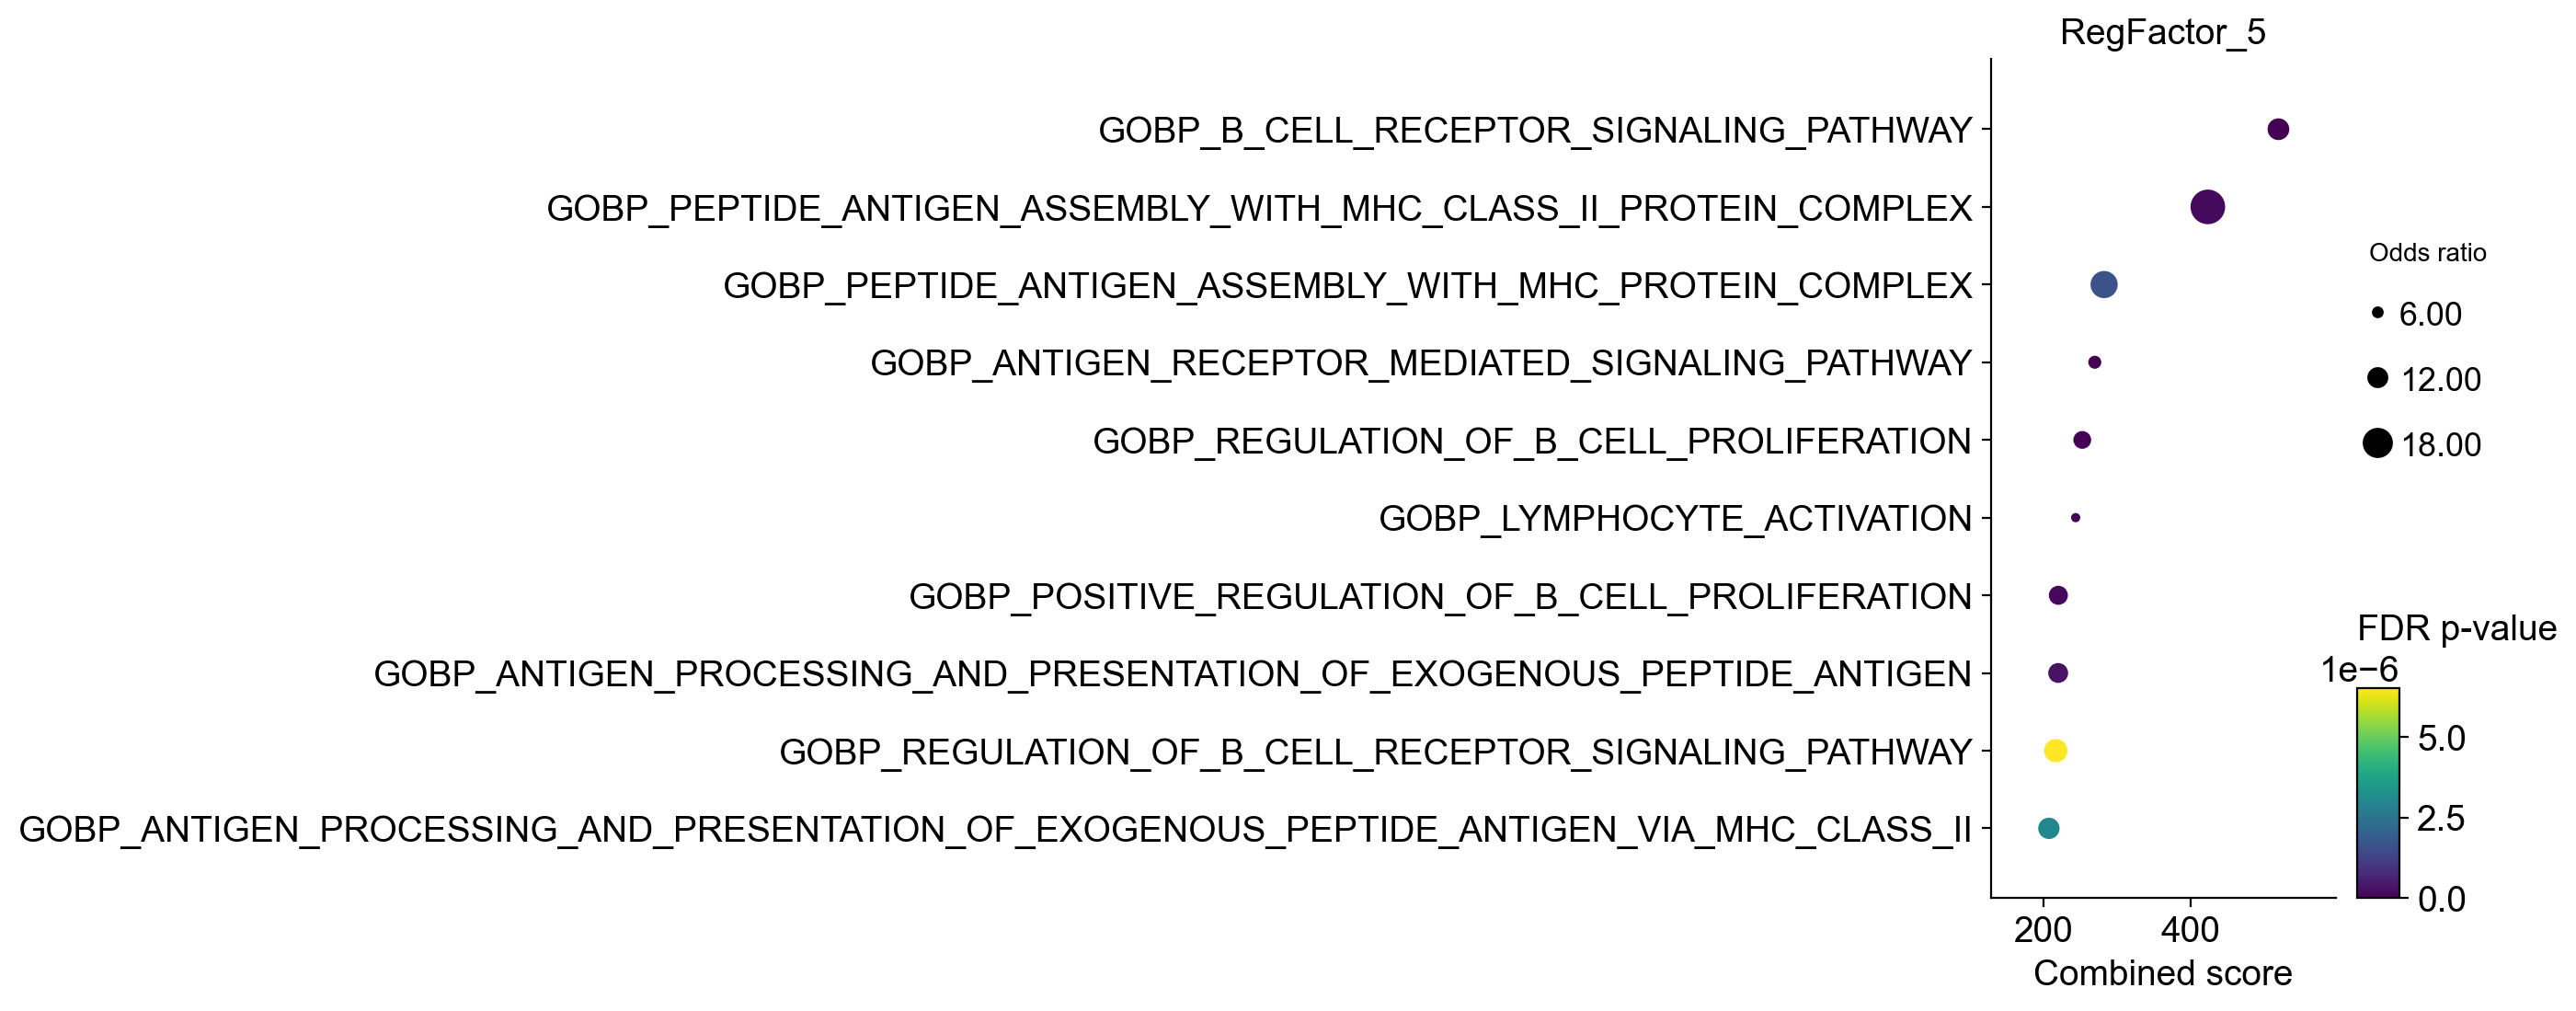

In [44]:
enr_pvals_dict = {}
regfactors_to_process = list(tg_dict.keys()) # Create a list to iterate over

for regfactor in regfactors_to_process:
    logg.info(f"Running ORA for regfactor: [bold cyan]{regfactor}[/bold cyan]")
    top_genes = tg_dict[regfactor].index

    # Use the run_ora method from the initialized object.
    # For best results, set n_background to the total number of genes 
    # detected in your experiment (e.g., len(adata.var_names)).
    enr_pvals = enricher.run_ora(
        gene_list=top_genes,
        n_background=20000, # Recommended: Replace with your actual background size
        top_n_results=10     # Show top 5 results in the console summary
    )
    
    # Store the full results
    enr_pvals_dict[regfactor] = enr_pvals

    # Check if the results DataFrame is not empty before plotting
    if enr_pvals.empty:
        logg.warning(f"No enrichment results found for {regfactor}. Skipping plot.")
        continue

    # Filter for significant results
    enr_pvals_fil = enr_pvals[enr_pvals['FDR p-value'] < 0.05]

    # Check if any significant terms remain after filtering
    if enr_pvals_fil.empty:
        logg.warning(f"No significant terms (FDR < 0.05) for {regfactor}. Skipping plot.")
        continue

    # Create the dot plot for the top 30 significant terms
    dc.pl.dotplot(
        enr_pvals_fil.sort_values('Combined score', ascending=False).head(30),
        x='Combined score',
        y='Term',
        s='Odds ratio',
        c='FDR p-value',
        cmap='viridis',
        scale=0.1,
        figsize=(3, 6)
    )
    plt.title(regfactor)
    plt.show()

## Network Visualization

In [48]:
from scmagnify.plotting import GRNVisualizer

In [45]:
custom_term_dict = {
    "GOBP_B_CELL_RECEPTOR_SIGNALING_PATHWAY": ['LYN', 'PTPRC', 'IGHM', 'PRKCB', 'BLK', 'IGKC', 'GRB2', 'FOXP1', 'NFKB1'],
    "GOBP_B_CELL_DIFFERENTIATION": ['PAX5', 'PTPRJ', 'PTPRC', 'IKZF3', 'IGHM', 'HDAC9', 'CARD11'],
    "GOBP_CHROMATIN_REMODELING": ['CHD7', 'NCOA3', 'HDAC9', 'SMCHD1', 'PRKCB', 'ATAD2', 'SETBP1', 'PCGF5', 'LBR', 'DPF3'],
    "GOBP_DNA_TOPOLOGICAL_CHANGE": ['TOP2A', 'TOP2B', 'HGMB1', "HGMB2"]
}

In [46]:
tf_list = ["EBF1", "PAX5", "IRF4", "TCF3", "SOX4"]
tg_list = tg_list = gdata["RegFactor"].varm["TG_loadings"].T.sort_values(by = "RegFactor_4", ascending=False).head(100).index

In [47]:
# get tg from custom terms
tg_list = []
for term, genes in custom_term_dict.items():
    tg_list.extend(genes)

In [49]:
vis = GRNVisualizer(gdata)

In [50]:
vis.prepare_network(
    regulon=None,
    tf_list=tf_list,  
    tg_list=tg_list,  
    add_suffixes=True,
    target_clusters=custom_term_dict
)

INFO     Building base TF-peak-gene triplet network...

INFO     Filtering triplet network using 'network' from gdata.uns...

INFO     Base network constructed with 91074 TF-peak-gene relationships.

INFO     Filtering network based on provided TF and/or Target Gene lists...

INFO     Final network contains 155 relationships after filtering.

INFO     Using provided manual target gene clusters.

         Manual Target Gene Clusters Summary          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Cluster                                ┃ Num Genes ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ GOBP_B_CELL_RECEPTOR_SIGNALING_PATHWAY │ 8         │
│ GOBP_B_CELL_DIFFERENTIATION            │ 6         │
│ GOBP_CHROMATIN_REMODELING              │ 10        │
└────────────────────────────────────────┴───────────┘

In [51]:
vis.add_continuous_mapping(
    node_type="TF",
    visual_property="size",
    modal="GRN", # Assumes gdata has a modal named 'activity'
    varm_key=("network_score", "degree_centrality"),
    map_range=(8, 12), # Map sizes from 8 to 25
    legend_title="Degree Centrality"
)

INFO     Added continuous mapping for 'TF' node 'size'.

In [52]:
vis.add_continuous_mapping(
    node_type="Target",
    visual_property="color",
    modal="RNA", # Assumes gdata has a modal named 'activity'
    map_range="Reds",
    layer="log1p_norm",
    legend_title="RNA Expression"
)

INFO     Added continuous mapping for 'Target' node 'color'.

In [54]:
vis.r_tf = 0.5
vis.r_ccre = 0.8
vis.r_target = 1.3

INFO     Calculating Network Layout...

INFO     Applying highlighting to specified nodes and edges...

INFO     Applying custom continuous mappings...

Adjusting 21 external target labels to prevent overlap...


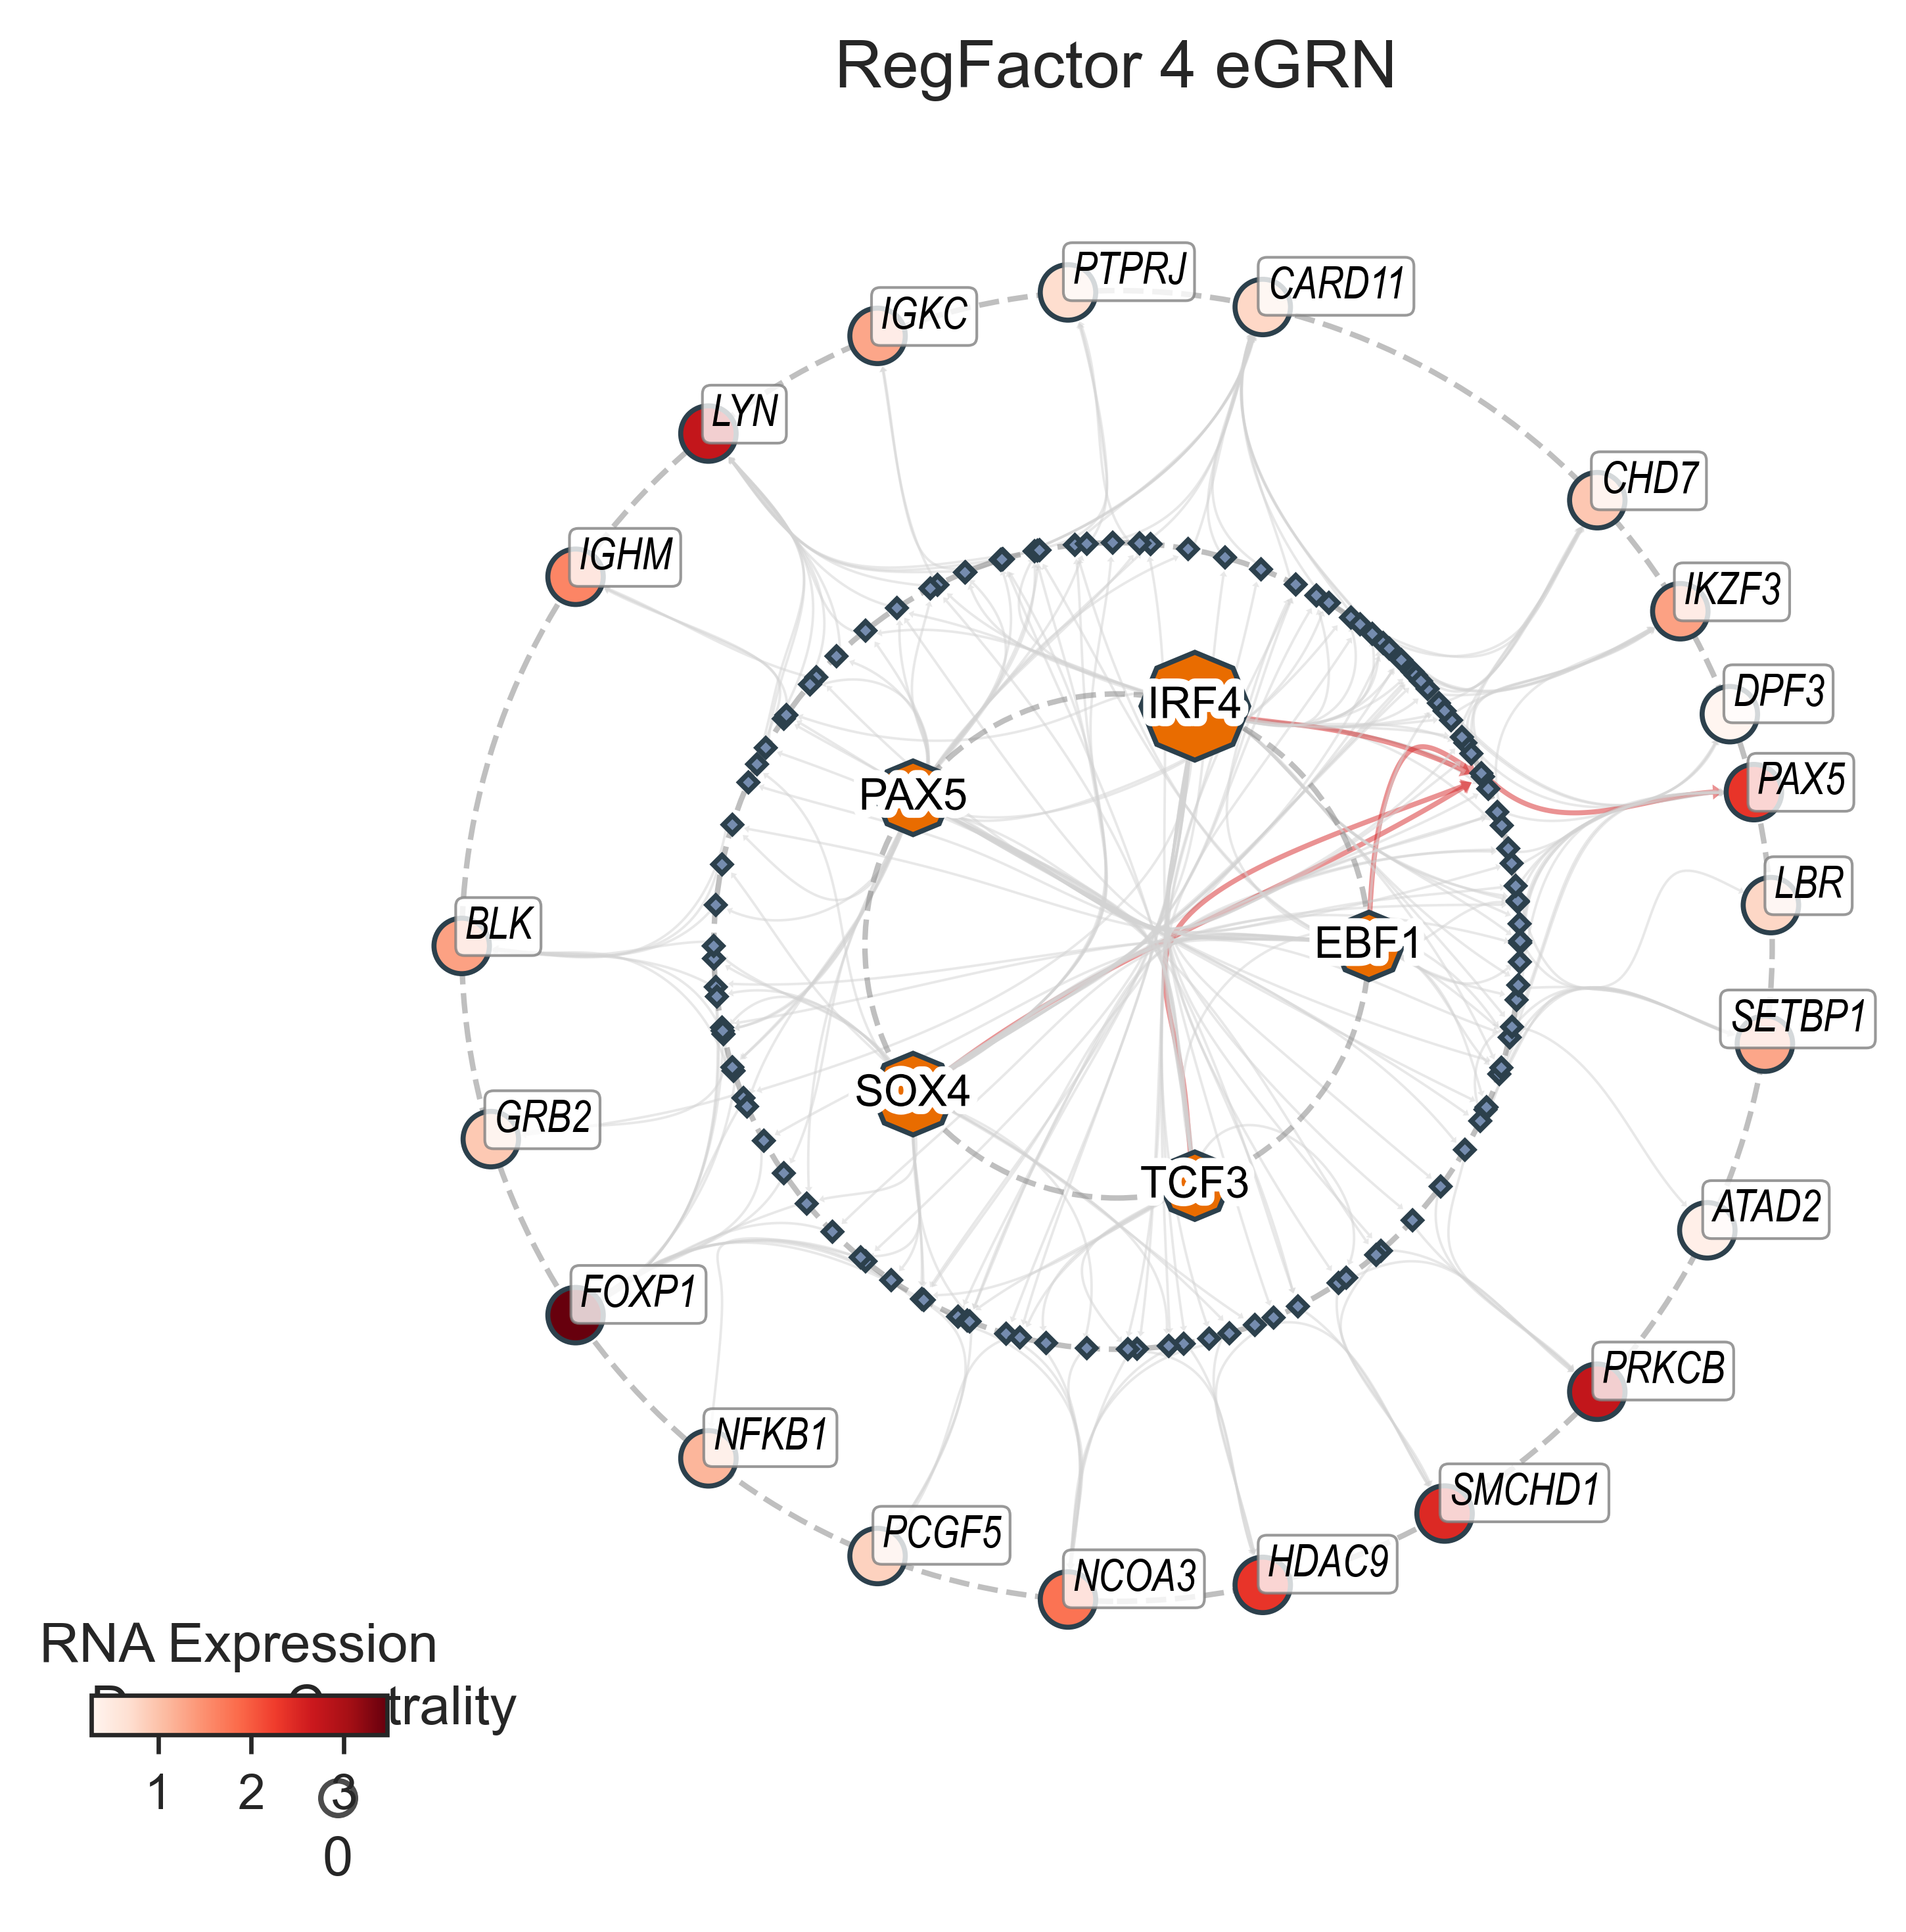

In [55]:
vis.plot(
    figsize=(5, 5), dpi=300, 
    title="RegFactor 4 eGRN", 
    title_fontsize=12,
    node_label_offset=0.2,
    node_edge_width=1,
    tf_layout_mode="uniform",
    label_offset_factor=1,
    label_mode='external',
    edge_layout='bundled',

    highlight={
        'Target': ['PAX5'],
        'cCRE': ['chr9:37029184-37029684'],
        'TF': ['EBF1', 'TCF3', 'PAX5', 'IRF4', 'SOX4']
    },
    interactive=False,
    jitter_strength=5,
    draw_cluster_wedges=False,
)

## Genomic Viewer

In [57]:
from scmagnify.plotting import GenomeViewer

In [61]:
fragment_files = {'IM-1393_BoneMarrow_TcellDep_1_multiome': '/mnt/TrueNas/project/chenxufeng//Data/PMID36973557_NatBiotechnol2023_T-cell-depleted/0_cellranger/BM_Tcelldep_Rep1_atac_fragments.tsv.gz',
                  'IM-1393_BoneMarrow_TcellDep_2_multiome': '/mnt/TrueNas/project/chenxufeng//Data/PMID36973557_NatBiotechnol2023_T-cell-depleted/0_cellranger/BM_Tcelldep_Rep2_atac_fragments.tsv.gz'}

In [62]:
viewer = GenomeViewer(
    data=gdata,
    modal="ATAC",
    fragment_files=fragment_files,
    cluster="celltype"
)

INFO     Attempting to auto-load peaks from 'ATAC' modality's .var_names...

INFO     ✅ Successfully auto-loaded 216477 peaks as 'Peaks'.

INFO     Attempting to auto-load links from gdata.uns['peak_gene_corrs']['filtered_corrs']...

INFO     ✅ Successfully auto-loaded 22745 links from gdata.

INFO     Preprocessing metadata...

/home/chenxufeng/WorkSpace/Git-repos/scMagnify/src/scmagnify/plotting/_genome_viewer.py:165: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.adata.obs["FragSample"] = self.adata.obs_names.str.split(self.barcode_delimiter).str.get(1).astype(str)


INFO     Loading and processing GTF...

INFO     Processing peaks for highlighting...

INFO                             peak  gene       cor      pval chrom     start  \                                 
         5731  chr9:36835204-36835704  PAX5  0.417219  0.002627  chr9  36835204                                    
         5732  chr9:36873230-36873730  PAX5  0.280841  0.045795  chr9  36873230                                    
         5733  chr9:36949396-36949896  PAX5  0.633355  0.001788  chr9  36949396                                    
         5734  chr9:36968883-36969383  PAX5  0.407278  0.007072  chr9  36968883                                    
         5735  chr9:36993858-36994358  PAX5  0.586656  0.009581  chr9  36993858                                    
         5736  chr9:36997154-36997654  PAX5  0.304038  0.022332  chr9  36997154                                    
         5737  chr9:37004392-37004892  PAX5  0.397404  0.007143  chr9  37004392                                    
         5738  chr9:37010921-37011421  PAX5  0.513678  0.002850  chr9  37010921                                    
         5739  chr9:37025579-37026079  PAX5  0.132025  0.086116  chr9  37025579                                    
         5740  chr9:37029184-37029684  PAX5  0.443045  0.018797  chr9  37029184                                    
         5741  chr9:37030276-37030776  PAX5  0.118639  0.063281  chr9  37030276                                    
         5742  chr9:37032656-37033156  PAX5  0.383195  0.002373  chr9  37032656                                    
         5743  chr9:37034085-37034585  PAX5  0.404153  0.029794  chr9  37034085                                    
         5744  chr9:37037198-37037698  PAX5  0.137647  0.090633  chr9  37037198                                    
         5745  chr9:37037840-37038340  PAX5  0.403106  0.007047  chr9  37037840                                    
         5746  chr9:37040435-37040935  PAX5  0.248222  0.039122  chr9  37040435                                    
         5747  chr9:37066033-37066533  PAX5  0.362238  0.014985  chr9  37066033                                    
         5748  chr9:37100720-37101220  PAX5  0.475527  0.001061  chr9  37100720                                    
                                                                                                                   
                    end                                                                                            
         5731  36835704                                                                                            
         5732  36873730                                                                                            
         5733  36949896                                                                                            
         5734  36969383                                                                                            
         5735  36994358                                                                                            
         5736  36997654                                                                                            
         5737  37004892                                                                                            
         5738  37011421                                                                                            
         5739  37026079                                                                                            
         5740  37029684                                                                                            
         5741  37030776                                                                                            
         5742  37033156                                                                                            
         5743  37034585                                                                                            
         5744  37037698                                 

INFO     Plotting 18 links.

INFO     Drawing highlights for 1 regions.

/home/chenxufeng/WorkSpace/Git-repos/scMagnify/src/scmagnify/plotting/_genome_viewer.py:850: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=0.5, h_pad=3)


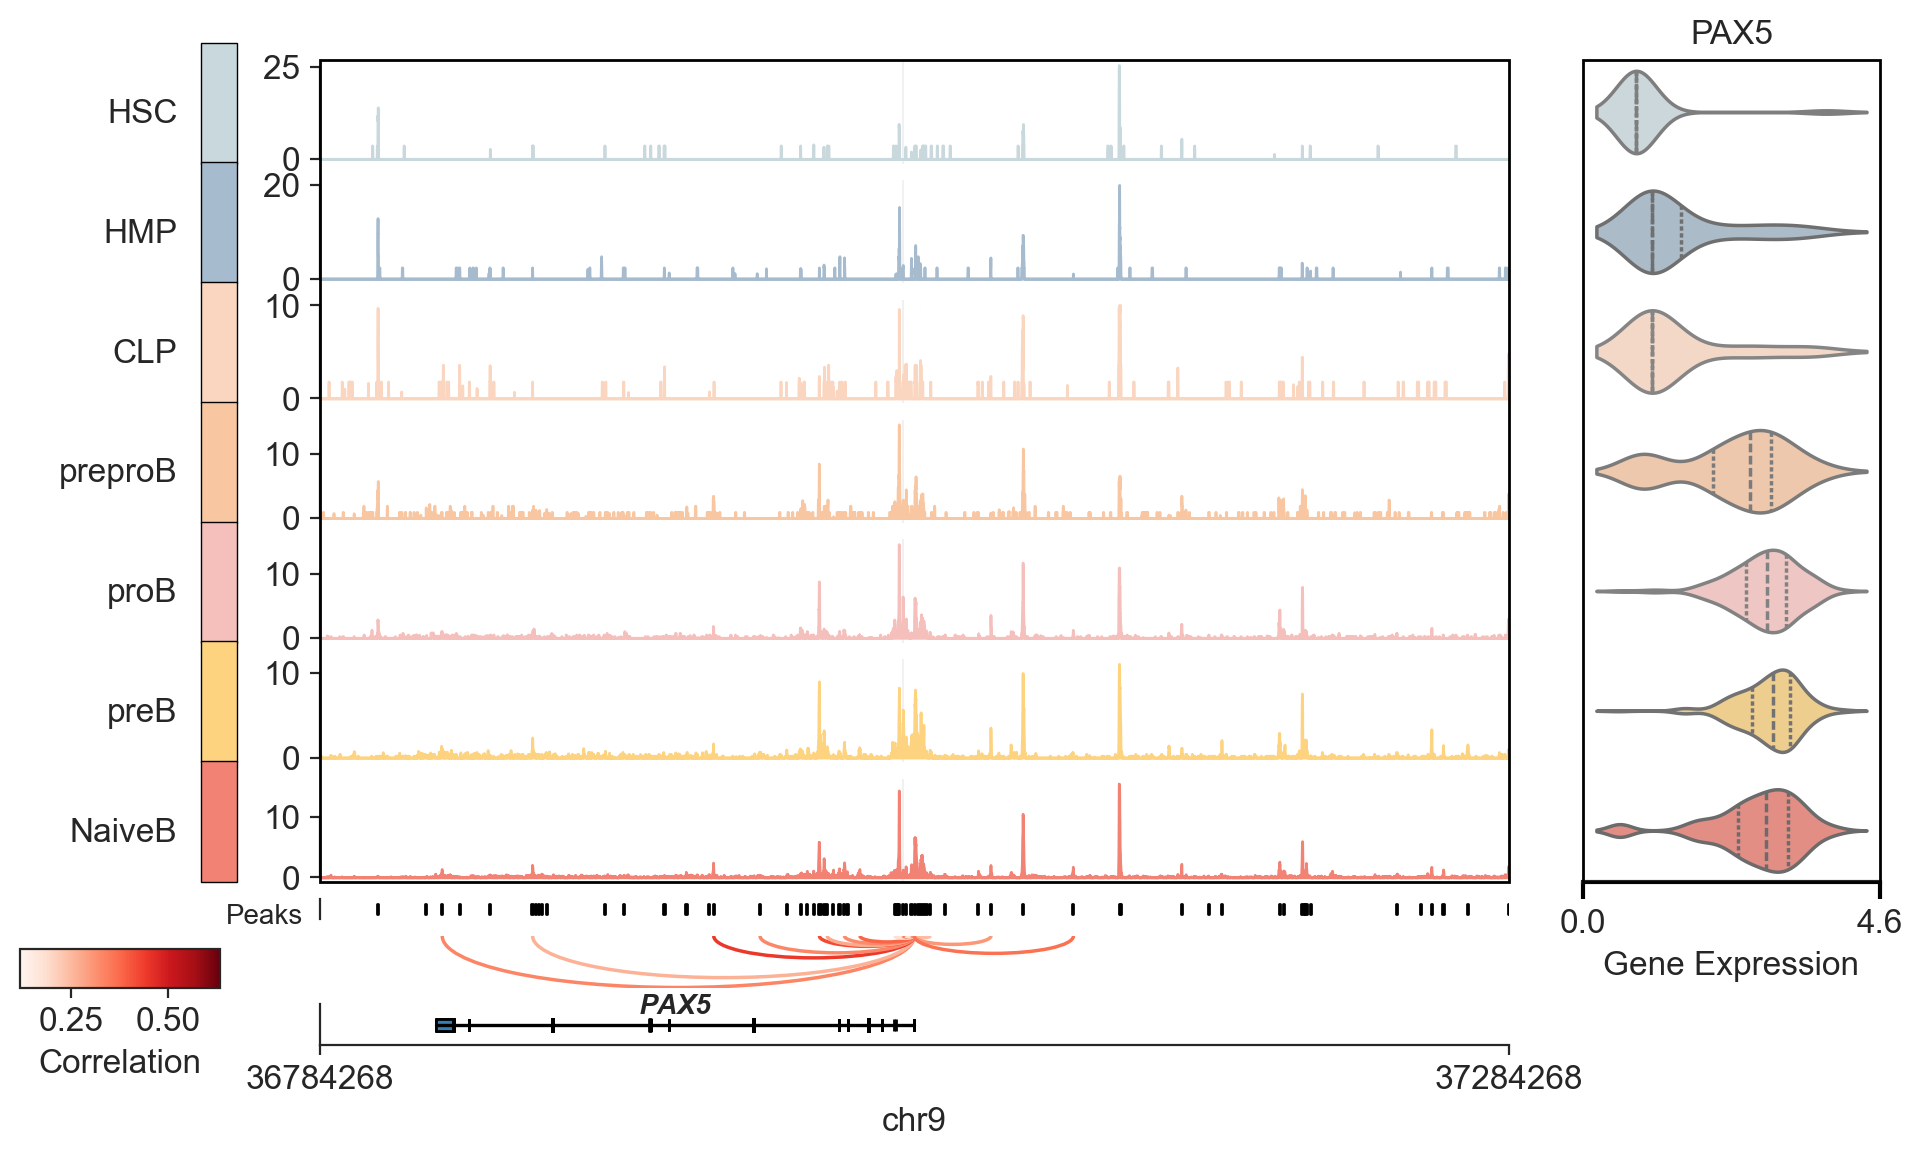

In [63]:
viewer.plot(
    anchor_gene="PAX5",
    theme="ticks",
    side_genes=["PAX5"],
    anchor_flank=250000,
    normalize=True,
    show_motif_logos=False,
    rasterize_coverage=True,
    highlight_peaks=['chr9:37029184-37029684'],
)

In [64]:
viewer.add_motifs(
    tfs=["EBF1", "IRF4", "SOX4", "TCF3"],
    motif_db="HOCOMOCOv11_HUMAN",
)

INFO     Added 4 new motifs. Total motifs: 4.

INFO     Added 4 motifs for plotting.

INFO     Processing peaks for highlighting...

INFO                             peak  gene       cor      pval chrom     start  \                                 
         5731  chr9:36835204-36835704  PAX5  0.417219  0.002627  chr9  36835204                                    
         5732  chr9:36873230-36873730  PAX5  0.280841  0.045795  chr9  36873230                                    
         5733  chr9:36949396-36949896  PAX5  0.633355  0.001788  chr9  36949396                                    
         5734  chr9:36968883-36969383  PAX5  0.407278  0.007072  chr9  36968883                                    
         5735  chr9:36993858-36994358  PAX5  0.586656  0.009581  chr9  36993858                                    
         5736  chr9:36997154-36997654  PAX5  0.304038  0.022332  chr9  36997154                                    
         5737  chr9:37004392-37004892  PAX5  0.397404  0.007143  chr9  37004392                                    
         5738  chr9:37010921-37011421  PAX5  0.513678  0.002850  chr9  37010921                                    
         5739  chr9:37025579-37026079  PAX5  0.132025  0.086116  chr9  37025579                                    
         5740  chr9:37029184-37029684  PAX5  0.443045  0.018797  chr9  37029184                                    
         5741  chr9:37030276-37030776  PAX5  0.118639  0.063281  chr9  37030276                                    
         5742  chr9:37032656-37033156  PAX5  0.383195  0.002373  chr9  37032656                                    
         5743  chr9:37034085-37034585  PAX5  0.404153  0.029794  chr9  37034085                                    
         5744  chr9:37037198-37037698  PAX5  0.137647  0.090633  chr9  37037198                                    
         5745  chr9:37037840-37038340  PAX5  0.403106  0.007047  chr9  37037840                                    
         5746  chr9:37040435-37040935  PAX5  0.248222  0.039122  chr9  37040435                                    
         5747  chr9:37066033-37066533  PAX5  0.362238  0.014985  chr9  37066033                                    
         5748  chr9:37100720-37101220  PAX5  0.475527  0.001061  chr9  37100720                                    
                                                                                                                   
                    end                                                                                            
         5731  36835704                                                                                            
         5732  36873730                                                                                            
         5733  36949896                                                                                            
         5734  36969383                                                                                            
         5735  36994358                                                                                            
         5736  36997654                                                                                            
         5737  37004892                                                                                            
         5738  37011421                                                                                            
         5739  37026079                                                                                            
         5740  37029684                                                                                            
         5741  37030776                                                                                            
         5742  37033156                                                                                            
         5743  37034585                                                                                            
         5744  37037698                                 

INFO     Plotting 18 links.

INFO     Drawing highlights for 1 regions.

/home/chenxufeng/WorkSpace/Git-repos/scMagnify/src/scmagnify/plotting/_genome_viewer.py:850: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=0.5, h_pad=3)


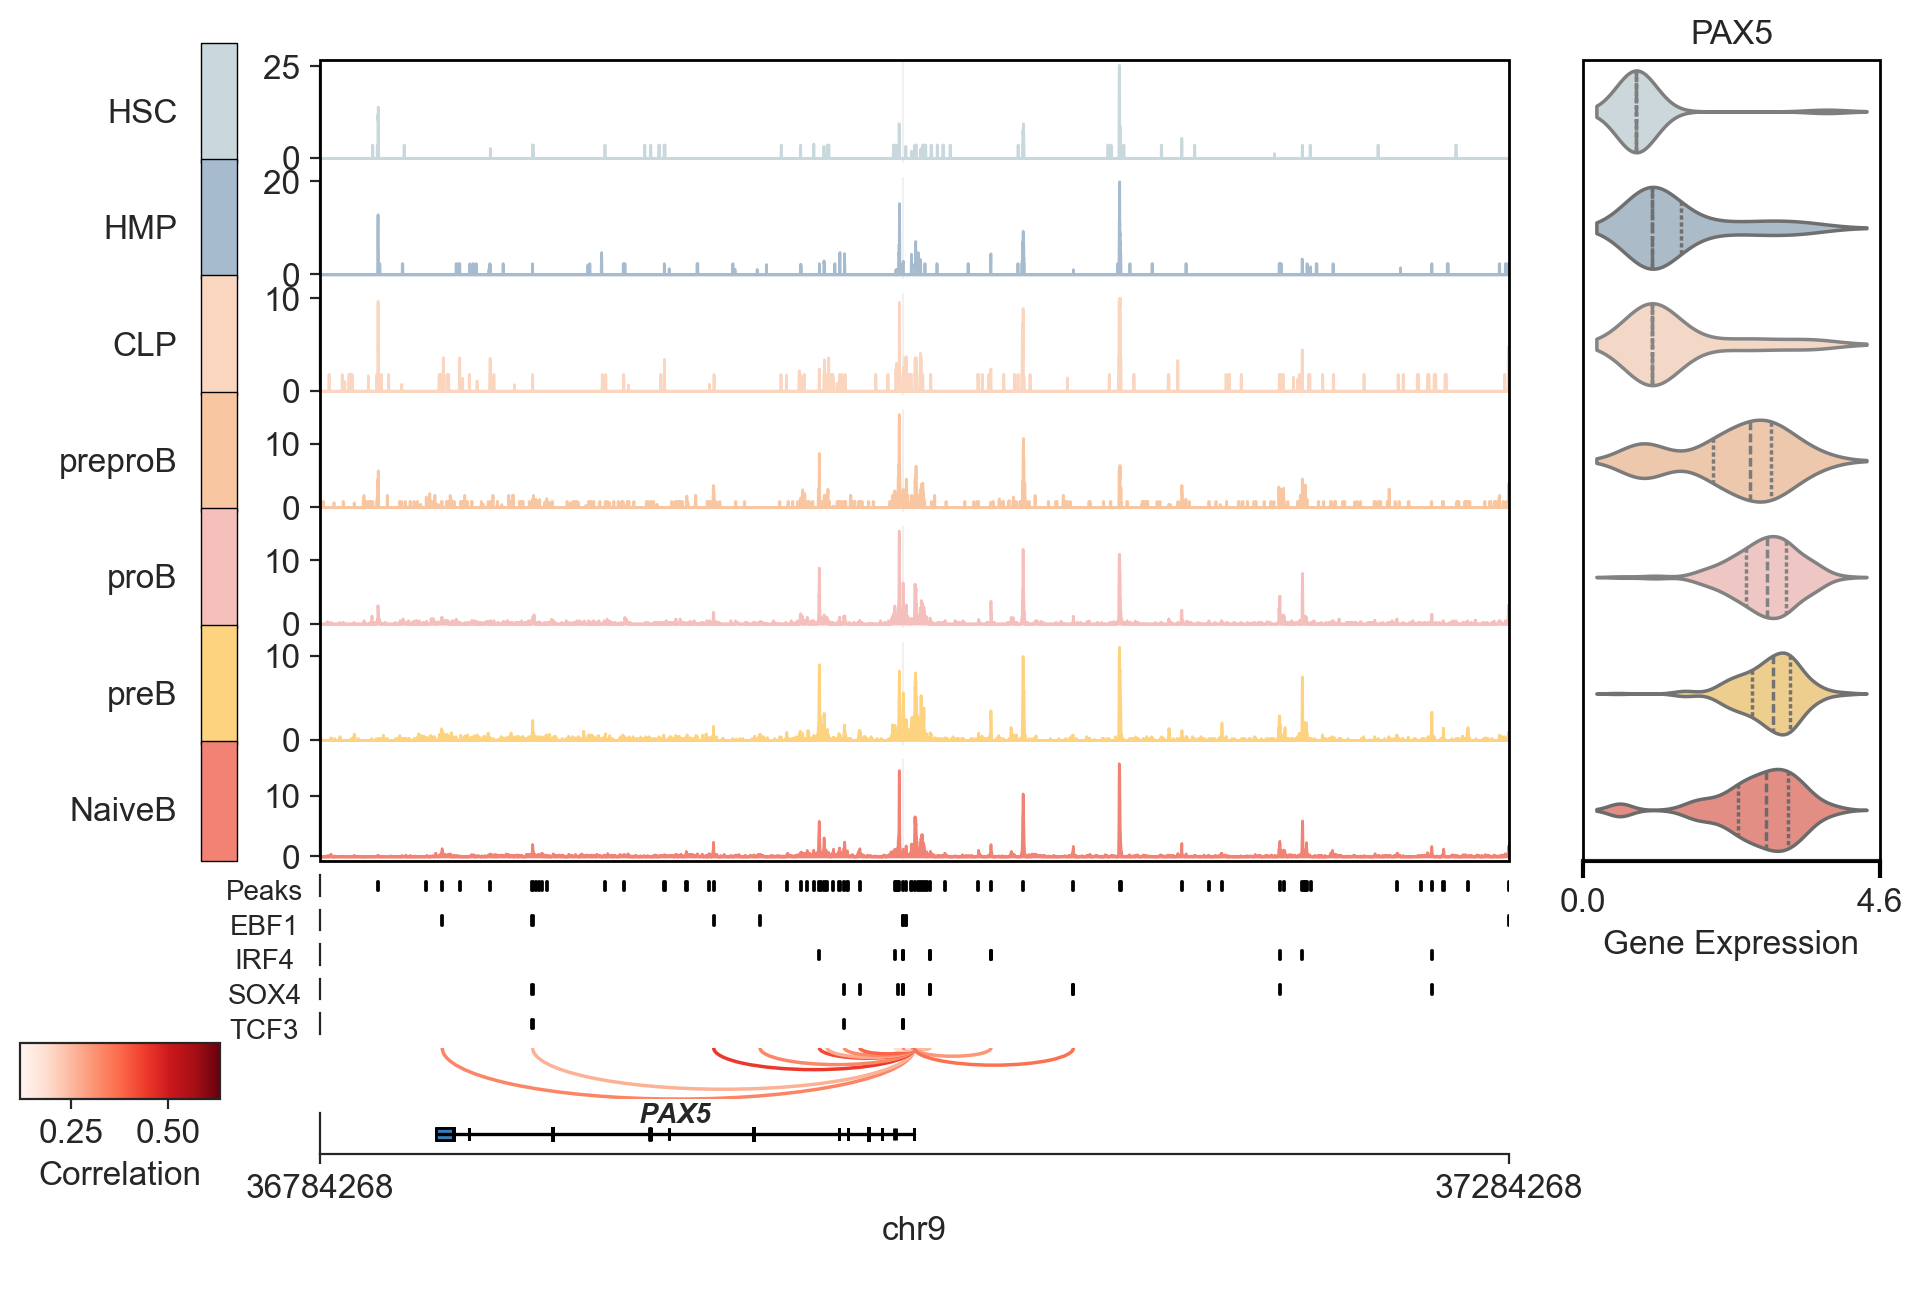

In [65]:
viewer.plot(
    anchor_gene="PAX5",
    theme="ticks",
    side_genes=["PAX5"],
    anchor_flank=250000,
    normalize=True,
    highlight_peaks=['chr9:37029184-37029684'],
    show_motif_logos=False,
    rasterize_coverage=True,
)

## Save the Data

In [ ]:
gdata.write(os.path.join(workDir, "gdata_tcelldep-bm_04_NaiveB.h5mu"))

## Closing matters

### What's next?

In this tutorial, you learned how to use `RegDecomp` to perform tensor decomposition, identifying combinatorial RegFactors (TF modules) and their target genes. You also learned how to visualize these modules, analyze their activity, and interpret their biological function using enrichment analysis.

This completes the core `scMagnify` workflow. For your next steps, we recommend:

-   **Applying this workflow to your own data**. You can now use this four-part framework to analyze your own single-cell multi-omic datasets from end to end.
-   Refer to the {doc}`API <scmagnify>` to explore all available functions and advanced parameter values that can be used to customize these computations for your specific biological questions.

If you encounter any bugs or have suggestions for new features, please open an [issue](https://github.com/your_repo_link/issues). For general questions, please post on the [scverse discourse](https://discourse.scverse.org/) or contact us at chenxufeng2022@sinh.ac.cn.

### Package versions

In [33]:
import session_info 
session_info.show()